In [1]:
# importing tool functions
import numpy as np
import matplotlib.pyplot as plt
from tools import utils, ml_tools
import pandas as pd
import numpy as np

In [2]:
# machine learning imports
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from sklearn.preprocessing import LabelBinarizer
from keras.utils import np_utils

In [3]:
# graphing tools
import seaborn as sns
from scipy.stats import sem
import matplotlib
import scienceplots

plt.style.use(['science', 'ieee','no-latex'])
matplotlib.rc('font', family='times new roman')

# time
import time 

In [4]:
# LTSM
import tensorflow as tf
from tensorflow.keras.datasets import imdb
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Embedding
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.layers import Bidirectional


In [5]:
dir_name_e = r'C:\Users\EfiaA\OneDrive - Imperial College London\Imperial academic work\University life\Y4\MSci project\Project_Coding\nlp-physicseducation\Pickledfiles'

# Year 1 & 2 Data

### 1. Import the year 1 & 2 Data

In [6]:
# import the yr2 labels
dir_csv3 = 'outputs/labels_cleaned_y1y2.csv'
df3 = pd.read_csv(dir_csv3, encoding='utf-8')

### 1.1 Apply TF-IDF on year 1 & 2 Data

In [7]:
# Epistemology (Reasoning Level)

# X_data -> Content of Lab report
X_y1y2_tf_rl             = np.array(ml_tools.tf_idf(df3['Content'].tolist()), dtype = object) # object
X_y1y2_tf_rl               = X_y1y2_tf_rl [1]
print(X_y1y2_tf_rl.shape)

# y_data ->  Epistemology label 
y_y1y2_tf_rl = df3['ReasoningLevel'].tolist() # list
lb           = LabelBinarizer()
lb.fit(y_y1y2_tf_rl )
y_y1y2_tf_rl  = lb.transform(y_y1y2_tf_rl )


(178, 7563)


In [8]:
# Argument Level

# X_data -> same as above
X_y1y2_tf_al               = X_y1y2_tf_rl
print(X_y1y2_tf_al.shape)

# y_data -> argument level
y_y1y2_tf_al = np.array(df3['ArgumentLevel'].tolist(), dtype = object)
lb = LabelBinarizer()
lb.fit(y_y1y2_tf_al)
y_y1y2_tf_al= lb.transform(y_y1y2_tf_al)



(178, 7563)


### 1.2 Apply BOW on year 1 & 2 Data

In [9]:
# Epistemology (Reasoning Level)

# X_data -> Content of Lab report 
wordvec_names, X_y1y2_bow_rl = ml_tools.BoW(df3['Content'].tolist())

# y_data -> Epistemology label 
y_y1y2_bow_rl = df3['ReasoningLevel'].tolist()
lb = LabelBinarizer()
lb.fit(y_y1y2_bow_rl )
y_y1y2_bow_rl  = lb.transform(y_y1y2_bow_rl )

In [10]:
# Argument Level

# X_data -> Content of Lab report 
X_y1y2_bow_al       = X_y1y2_bow_rl

# y_data -> Argument level labels 

y_y1y2_bow_al      = df3['ArgumentLevel'].tolist()
lb                 = LabelBinarizer()
lb.fit(y_y1y2_bow_al)
y_y1y2_bow_al      = lb.transform(y_y1y2_bow_al)

# Neural Network Functions

In [11]:
# Standard Neural Network

def NN(model1, input1, ephs, X_t, y_t, X_test, y_test):
    maxlen = 100 
    model = model1
    model.add(layers.Dense(12, input_dim = input, activation  = 'relu'))
    model.add(layers.Dense(8, input_dim = input, activation  = 'relu'))
    model.add(layers.Dense(1,activation = 'sigmoid'))
    model.add(layers.Flatten())
    model.compile(loss= 'binary_crossentropy', optimizer= 'adam', metrics= ['accuracy'])
    model.build(input1)
    model.summary()
    history = model.fit(X_t,y_t,epochs = ephs, verbose=True, validation_data=(X_test, y_test), batch_size=30 )
    return history


embedding_vecor_length = 32
top_words = 5000

def LTSM(model1, input1, ephs, X_t, y_t, X_test, y_test):
    maxlen = 100 
    model = model1
    model.add(Embedding(5000, 32, input_length=input1))
    model.add(Bidirectional(LSTM(100, dropout=0.2, recurrent_dropout=0.2)))
    model.add(Dense(1, activation='sigmoid'))
    model.add(layers.Flatten())
    model.compile(loss= 'binary_crossentropy', optimizer= 'adam', metrics= ['accuracy'])
    model.build(input1)
    model.summary()
    history = model.fit(X_t,y_t,epochs = ephs, verbose=True, validation_data=(X_test, y_test), batch_size=30 )
    return history

def LTSM_data(X, y,t_size,epoch_no, str_dataname,str_featext, str_year, dir):
    accuracies = []
    accuracies_sem = []
    loss = []
    dummy = []
    dummy_loss = []
    for i in t_size:
        X_train_b, X_test_b, y_train_b, y_test_b = train_test_split(X, y , train_size = i)
        input = X_train_b.shape[1]
        #input = len(y_train_b)
        nn1 = LTSM(Sequential(), input, epoch_no, X_train_b, y_train_b, X_test_b, y_test_b)
        dummy.append(nn1.history['accuracy'])
        dummy_loss.append(nn1.history['loss'])


    for array in dummy:
        accuracies.append(np.sum(array)/len(array))
        accuracies_sem.append(sem(array))
    
    for array in dummy_loss:
        loss.append(np.sum(array)/len(array))

    dict_rl = {'trainsize':t_size, 'accuracy':accuracies, 'sem': accuracies_sem, 'loss':loss}
    acc_rl_bow = pd.DataFrame(dict_rl)
    utils.save_as_pickle_file(acc_rl_bow,'NN_{}_{}_{}_{}ephs_recent'. format(str_year, str_featext,str_dataname,'1000'), dir)
    #name = 'NN_{}_{}_trainsize_accuracy_sem_{}ephs_{}'. format(str_dataname,str_featext,'1000', str_year)
    return acc_rl_bow


def NN_dataframe(X, y, epoch_no, tratio):
    accuracies = []
    accuracies_std = []
    loss = []
    dummy = []
    dummy_loss = []
    start_time = time.time()
    print(start_time)
   
    X_train_b, X_test_b, y_train_b, y_test_b = train_test_split(X, y , train_size = tratio)
    input = X_train_b.shape[1]
    nn1 = NN(Sequential(), input, epoch_no, X_train_b, y_train_b, X_test_b, y_test_b)
    dummy.append(nn1.history['accuracy'])
    loss.append(nn1.history['loss'])

    dictionary = {'accuracy':dummy, 'loss':loss}
    Dataframe = pd.DataFrame(dictionary)
    totaltime = time.time() - start_time
    return Dataframe



def NN_data(X, y,t_size,epoch_no, str_dataname,str_featext, str_year, dir):
    accuracies = []
    accuracies_sem = []
    loss = []
    dummy = []
    dummy_loss = []
    for i in t_size:
        X_train_b, X_test_b, y_train_b, y_test_b = train_test_split(X, y , train_size = i)
        input = X_train_b.shape[1]
        #input = len(y_train_b)
        nn1 = NN(Sequential(), input, epoch_no, X_train_b, y_train_b, X_test_b, y_test_b)
        dummy.append(nn1.history['accuracy'])
        dummy_loss.append(nn1.history['loss'])


    for array in dummy:
        accuracies.append(np.sum(array)/len(array))
        accuracies_sem.append(sem(array))
    
    for array in dummy_loss:
        loss.append(np.sum(array)/len(array))

    dict_rl = {'trainsize':t_size, 'accuracy':accuracies, 'sem': accuracies_sem, 'loss':loss}
    acc_rl_bow = pd.DataFrame(dict_rl)
    utils.save_as_pickle_file(acc_rl_bow,'NN_{}_{}_{}_{}ephs_recent'. format(str_year, str_featext,str_dataname,'1000'), dir)
    #name = 'NN_{}_{}_trainsize_accuracy_sem_{}ephs_{}'. format(str_dataname,str_featext,'1000', str_year)
    return acc_rl_bow

def plot(dframe_train, dframe_acc, dframe_sem):
    plt.plot(dframe_train, dframe_acc, 'o')
    plt.errorbar(dframe_train, dframe_acc, yerr = dframe_sem, markersize=0.5, capsize=3, elinewidth=1, color= 'black' )
    plt.xlabel(' Training size')
    plt.ylabel('Accuracy score')

    # save figure 
    # filepath = 'outputs/NN-RL-BOW-1000ephs_NEW'
    # plt.savefig(filepath)
    return




### 2.1 Epistomology - TFIDF

In [12]:
# train and split the data
# Choose a 0.7 train size
# 5000
X_train_t, X_test_t, y_train_t, y_test_t = train_test_split(X_y1y2_tf_rl, y_y1y2_tf_rl , train_size = 0.7)
input = X_train_t.shape[1]
print(input)


7563


In [133]:
# Training the neural network

ephs = 1000 #no of epochs 
train_sizes = [0.5,0.6,0.7,0.8,0.9] 

# str_dataname,str_featext, str_year, dir
from time import time

start = time() # start time

# train nn for: Epistemology (reasoning level) data - bow - y1y2
Epist_data_tf_rl = NN_data(X_y1y2_tf_rl, y_y1y2_tf_rl,train_sizes,ephs, 'EPISTEMOLOGY', 'TFIDF', 'y1y2', dir_name_e )
print('Time- NN_bow_rl_y1y2:', time() - start) 

Model: "sequential_36"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_103 (Dense)           (None, 12)                90768     
                                                                 
 dense_104 (Dense)           (None, 8)                 104       
                                                                 
 dense_105 (Dense)           (None, 1)                 9         
                                                                 
 flatten_35 (Flatten)        (None, 1)                 0         
                                                                 
Total params: 90,881
Trainable params: 90,881
Non-trainable params: 0
_________________________________________________________________
Epoch 1/1000
3/3 [==============================] - 1s 168ms/step - loss: 0.6863 - accuracy: 0.7500 - val_loss: 0.6774 - val_accuracy: 0.7500
Epoch 2/1000
3/3 [=====================

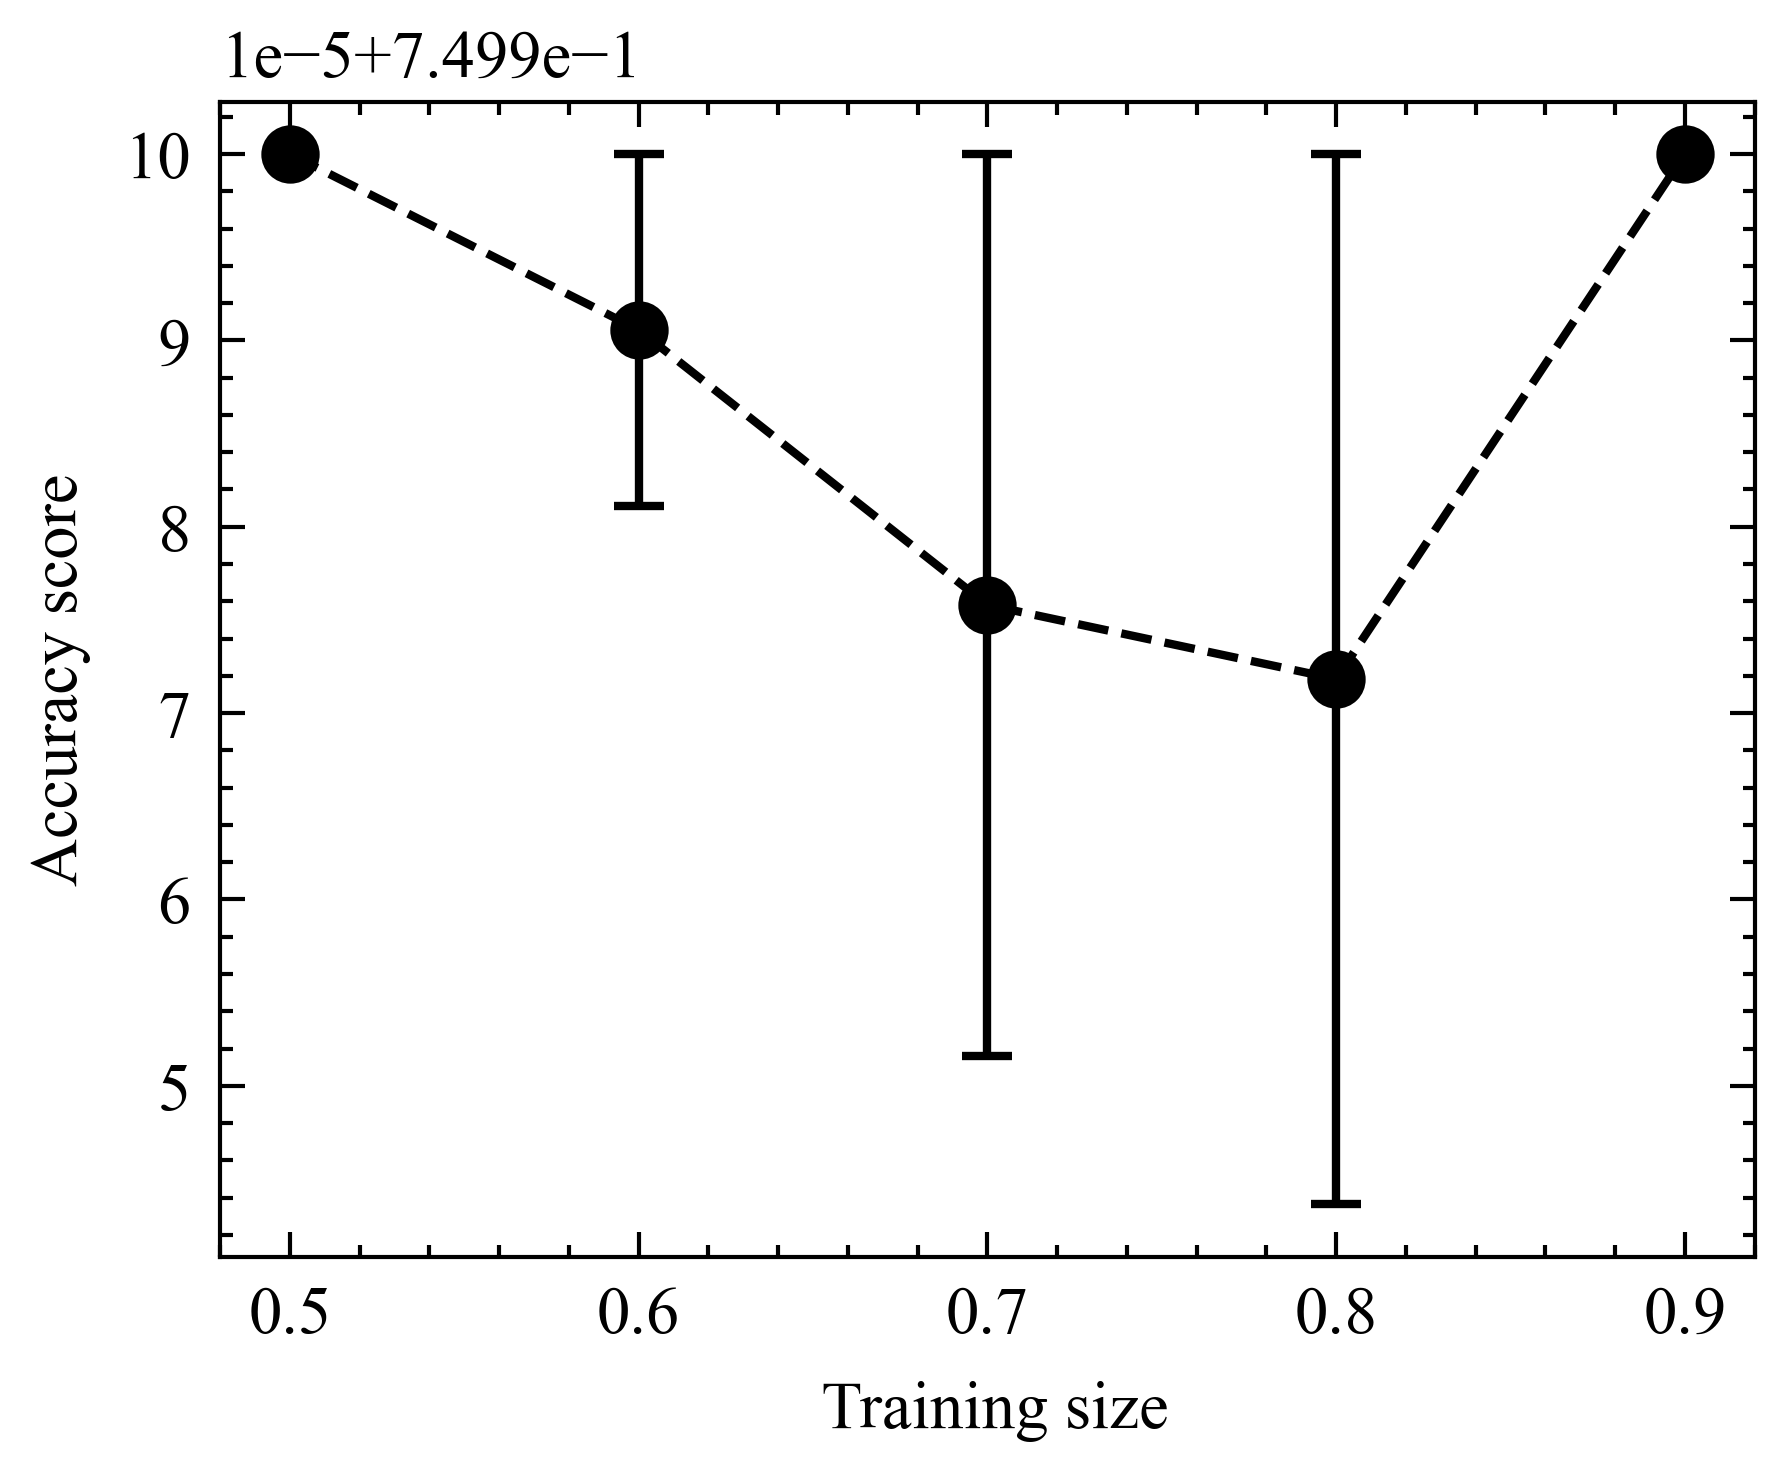

In [17]:

df_unpic_epist_tf_rl = utils.load_pickle_file_to_df('NN_y1y2_TFIDF_EPISTEMOLOGY_1000ephs_recent', dir_name_e)
plot(df_unpic_epist_tf_rl['trainsize'], df_unpic_epist_tf_rl['accuracy'], df_unpic_epist_tf_rl['sem'])

### 2.2 Epistomology - BOW

In [138]:
# str_dataname,str_featext, str_year, dir
from time import time

start = time() # start time

# train nn for: Epistemology (reasoning level) data - bow - y1y2
Epist_data_bow_rl = NN_data(X_y1y2_bow_rl, y_y1y2_bow_rl,train_sizes,ephs, 'EPISTEMOLOGY', 'BOW', 'y1y2', dir_name_e)
print('Time- NN_bow_rl_y1y2:', time() - start) 

Model: "sequential_41"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_118 (Dense)           (None, 12)                90768     
                                                                 
 dense_119 (Dense)           (None, 8)                 104       
                                                                 
 dense_120 (Dense)           (None, 1)                 9         
                                                                 
 flatten_40 (Flatten)        (None, 1)                 0         
                                                                 
Total params: 90,881
Trainable params: 90,881
Non-trainable params: 0
_________________________________________________________________
Epoch 1/1000
3/3 [==============================] - 2s 208ms/step - loss: 1.5494 - accuracy: 0.4691 - val_loss: 0.9516 - val_accuracy: 0.7500
Epoch 2/1000
3/3 [=====================

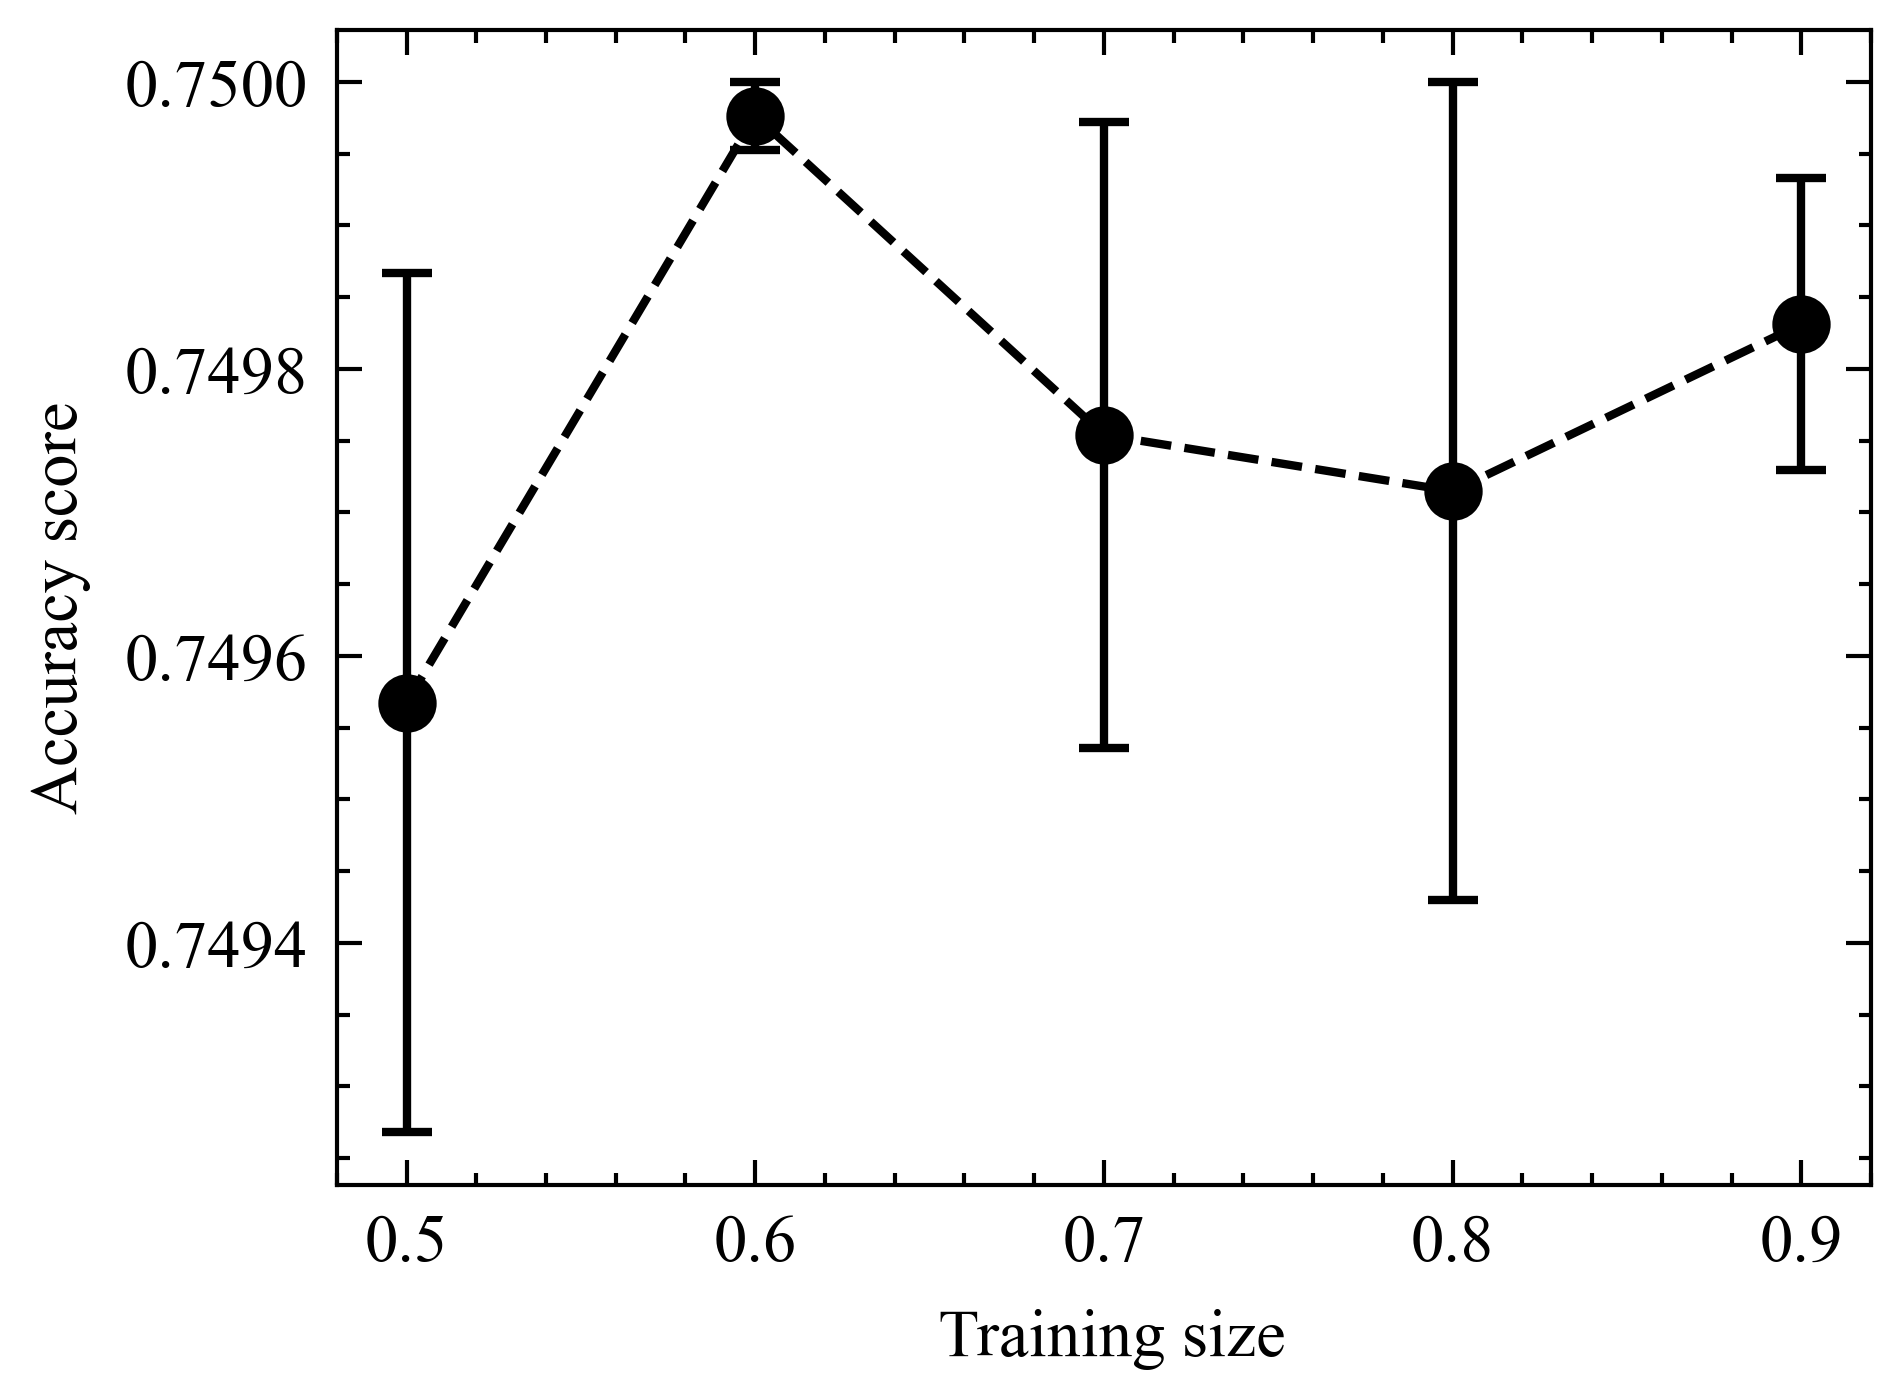

In [18]:
df_unpic_epist_bow_rl = utils.load_pickle_file_to_df('NN_y1y2_BOW_EPISTEMOLOGY_1000ephs_recent', dir_name_e)
plot(df_unpic_epist_bow_rl['trainsize'], df_unpic_epist_bow_rl['accuracy'], df_unpic_epist_bow_rl['sem'])

### 2.3 Argument Level - TFIDF

In [178]:
# str_dataname,str_featext, str_year, dir
from time import time

start = time() # start time
Arg_data_tfidf = NN_data(X_y1y2_tf_al, y_y1y2_tf_al, train_sizes, ephs, 'ARGUMENTLEVEL', 'TFIDF', 'y1y2', dir_name_e)
print('Time- NN_bow_rl_y1y2:', time() - start) 


Model: "sequential_54"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_157 (Dense)           (None, 12)                90768     
                                                                 
 dense_158 (Dense)           (None, 8)                 104       
                                                                 
 dense_159 (Dense)           (None, 1)                 9         
                                                                 
 flatten_53 (Flatten)        (None, 1)                 0         
                                                                 
Total params: 90,881
Trainable params: 90,881
Non-trainable params: 0
_________________________________________________________________
Epoch 1/1000
3/3 [==============================] - 1s 130ms/step - loss: 0.6938 - accuracy: 0.3955 - val_loss: 0.6914 - val_accuracy: 0.8000
Epoch 2/1000
3/3 [=====================

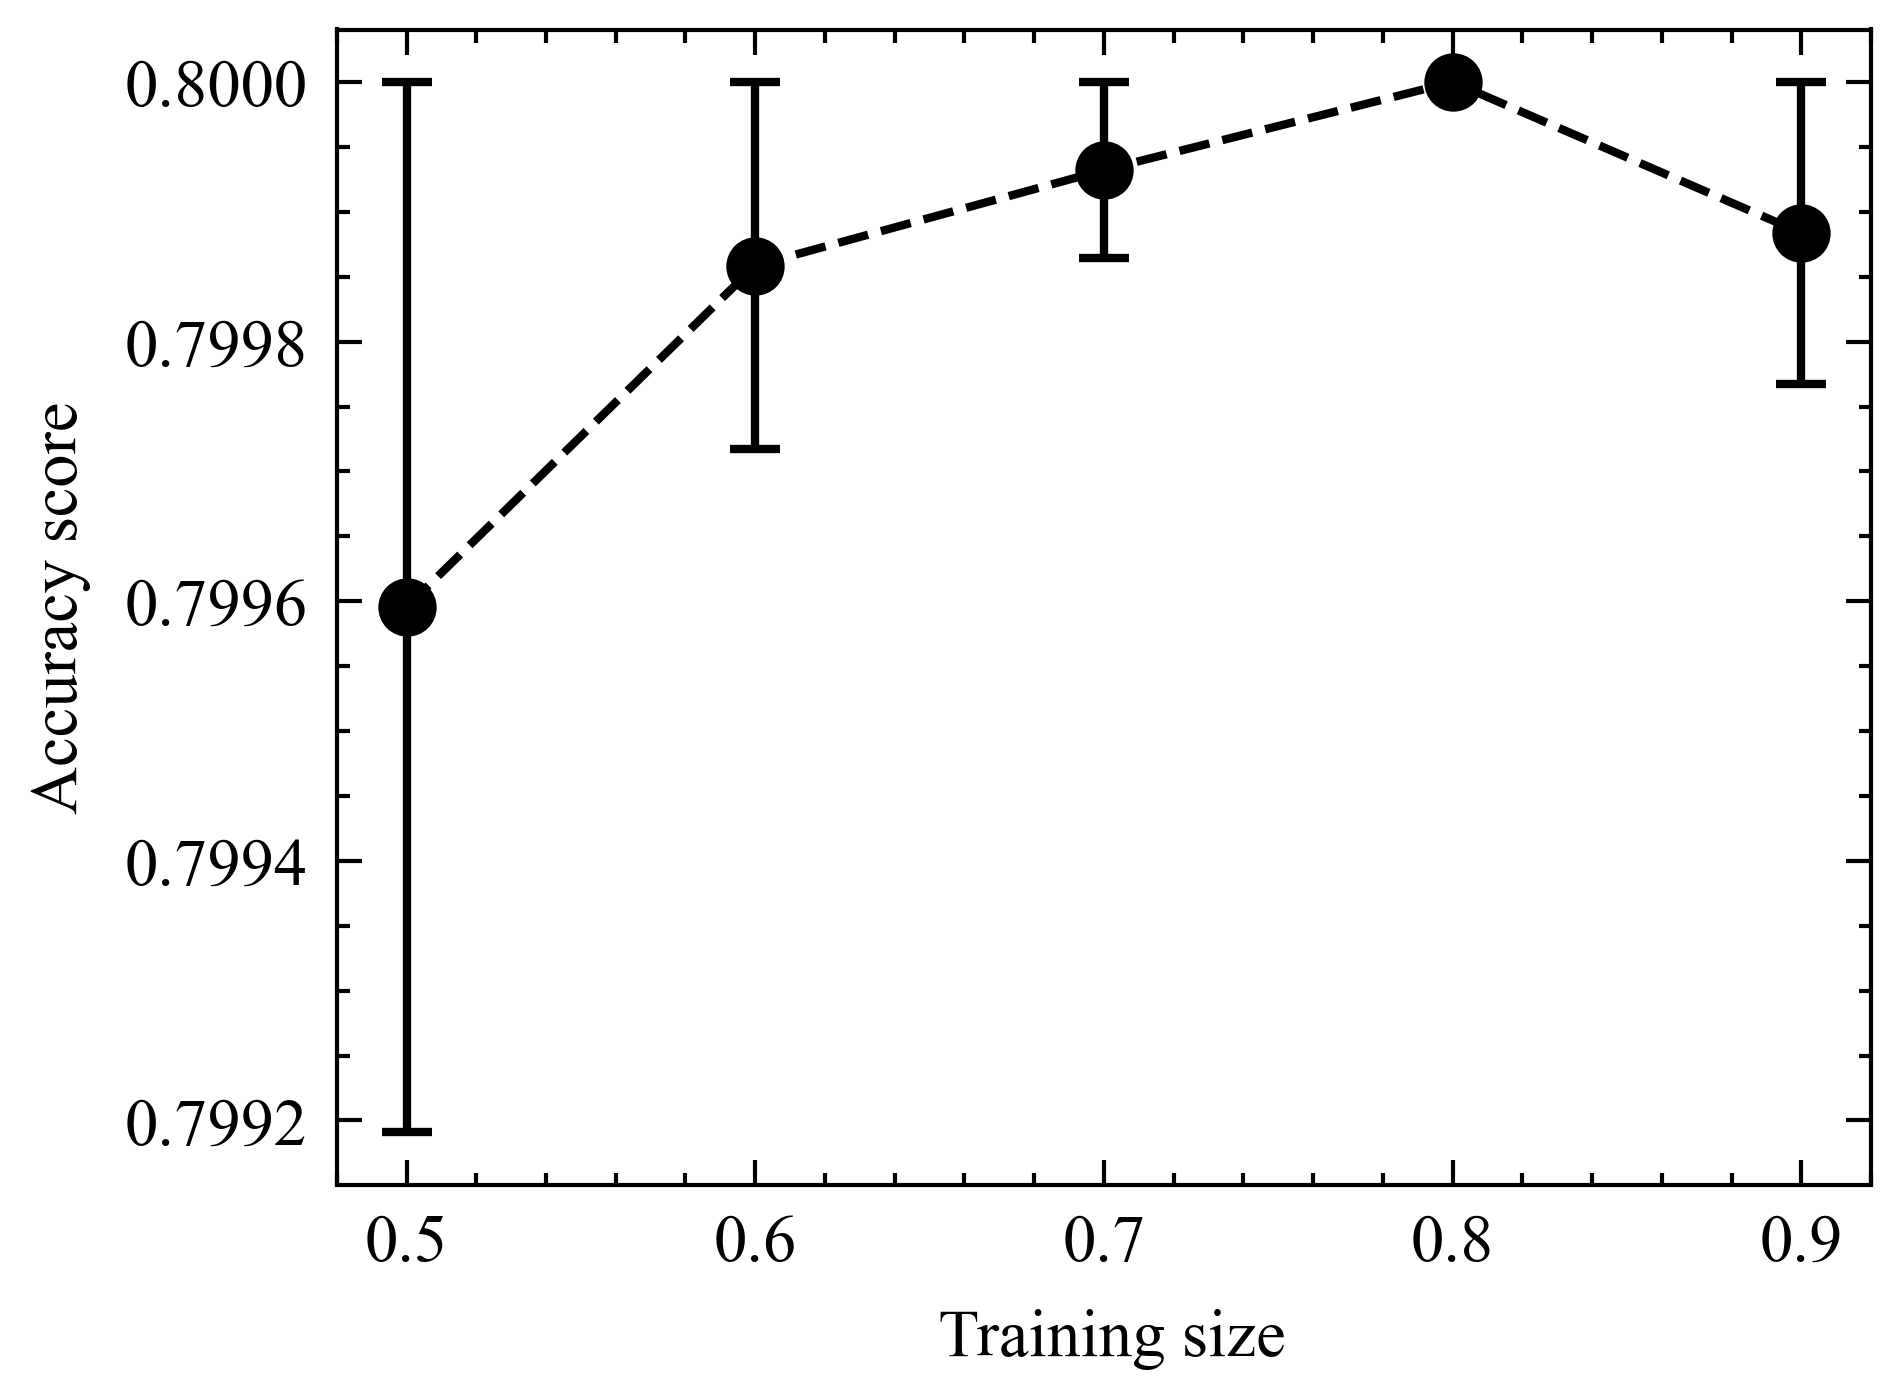

In [19]:
df_unpic_arg_tfidf_al = utils.load_pickle_file_to_df('NN_y1y2_TFIDF_ARGUMENTLEVEL_1000ephs_recent', dir_name_e)
plot(df_unpic_arg_tfidf_al['trainsize'], df_unpic_arg_tfidf_al['accuracy'],df_unpic_arg_tfidf_al['sem'])

### 2.4 Argument Level - BOW

In [177]:
# str_dataname,str_featext, str_year, dir
from time import time

start = time() # start time
Arg_data_bow = NN_data(X_y1y2_bow_al, y_y1y2_bow_al,train_sizes, ephs, 'ARGUMENTLEVEL', 'BOW', 'y1y2', dir_name_e)
print('Time- NN_tf_al_y1y2:', time() - start) 

Model: "sequential_53"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_154 (Dense)           (None, 12)                90768     
                                                                 
 dense_155 (Dense)           (None, 8)                 104       
                                                                 
 dense_156 (Dense)           (None, 1)                 9         
                                                                 
 flatten_52 (Flatten)        (None, 1)                 0         
                                                                 
Total params: 90,881
Trainable params: 90,881
Non-trainable params: 0
_________________________________________________________________
Epoch 1/1000
3/3 [==============================] - 1s 164ms/step - loss: 0.6343 - accuracy: 0.7596 - val_loss: 0.5926 - val_accuracy: 0.8000
Epoch 2/1000
3/3 [=====================

KeyboardInterrupt: 

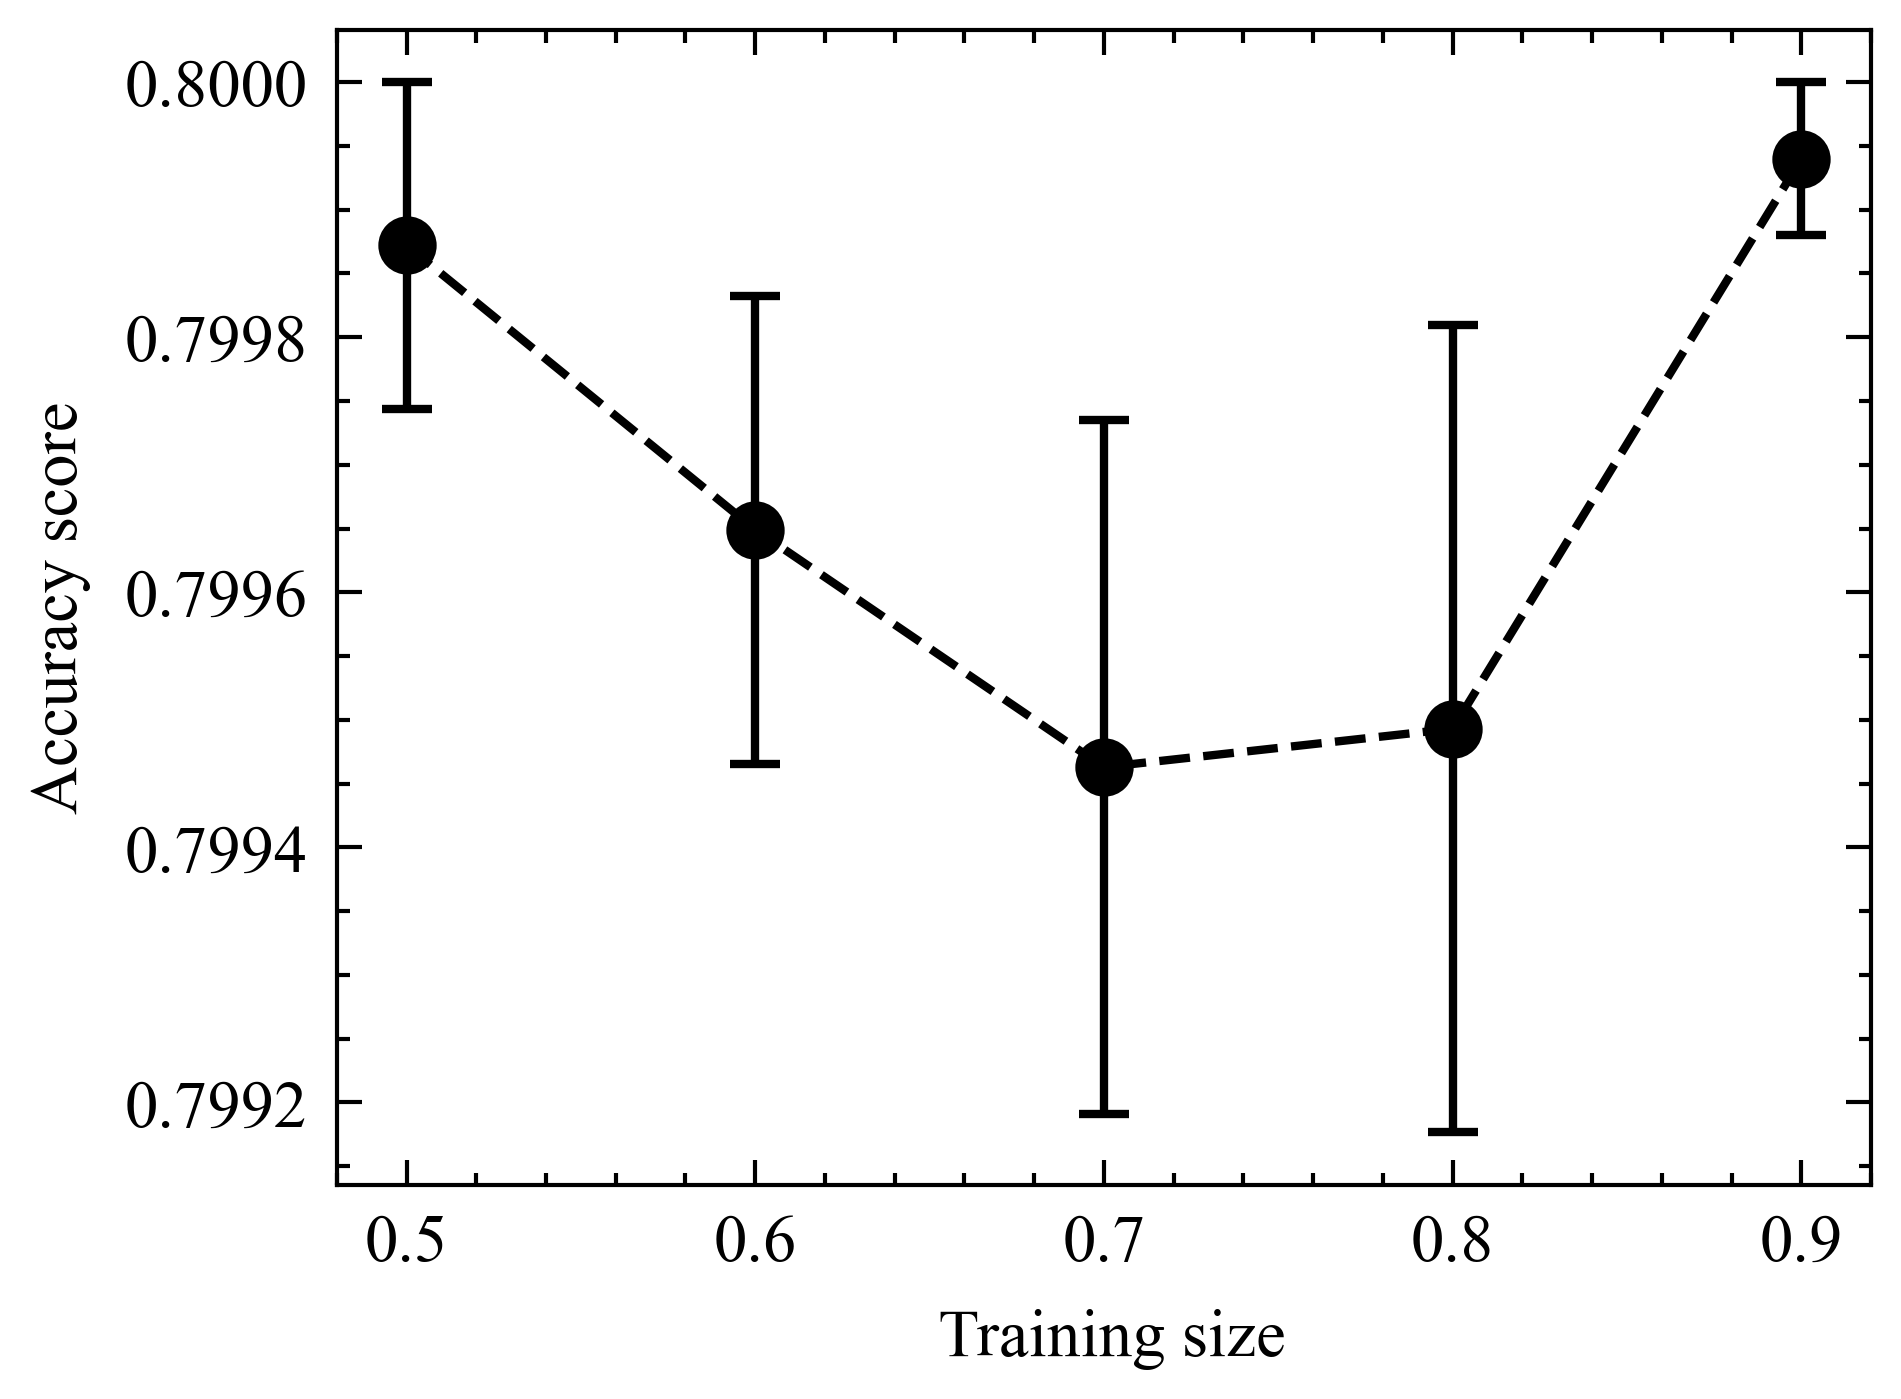

In [20]:
df_unpic_arg_bow_rl = utils.load_pickle_file_to_df('NN_y1y2_BOW_ARGUMENTLEVEL_1000ephs_recent', dir_name_e)
plot(df_unpic_arg_bow_rl['trainsize'], df_unpic_arg_bow_rl['accuracy'], df_unpic_arg_bow_rl['sem'])

# All Y1 & Y2 Feature Extracted Data

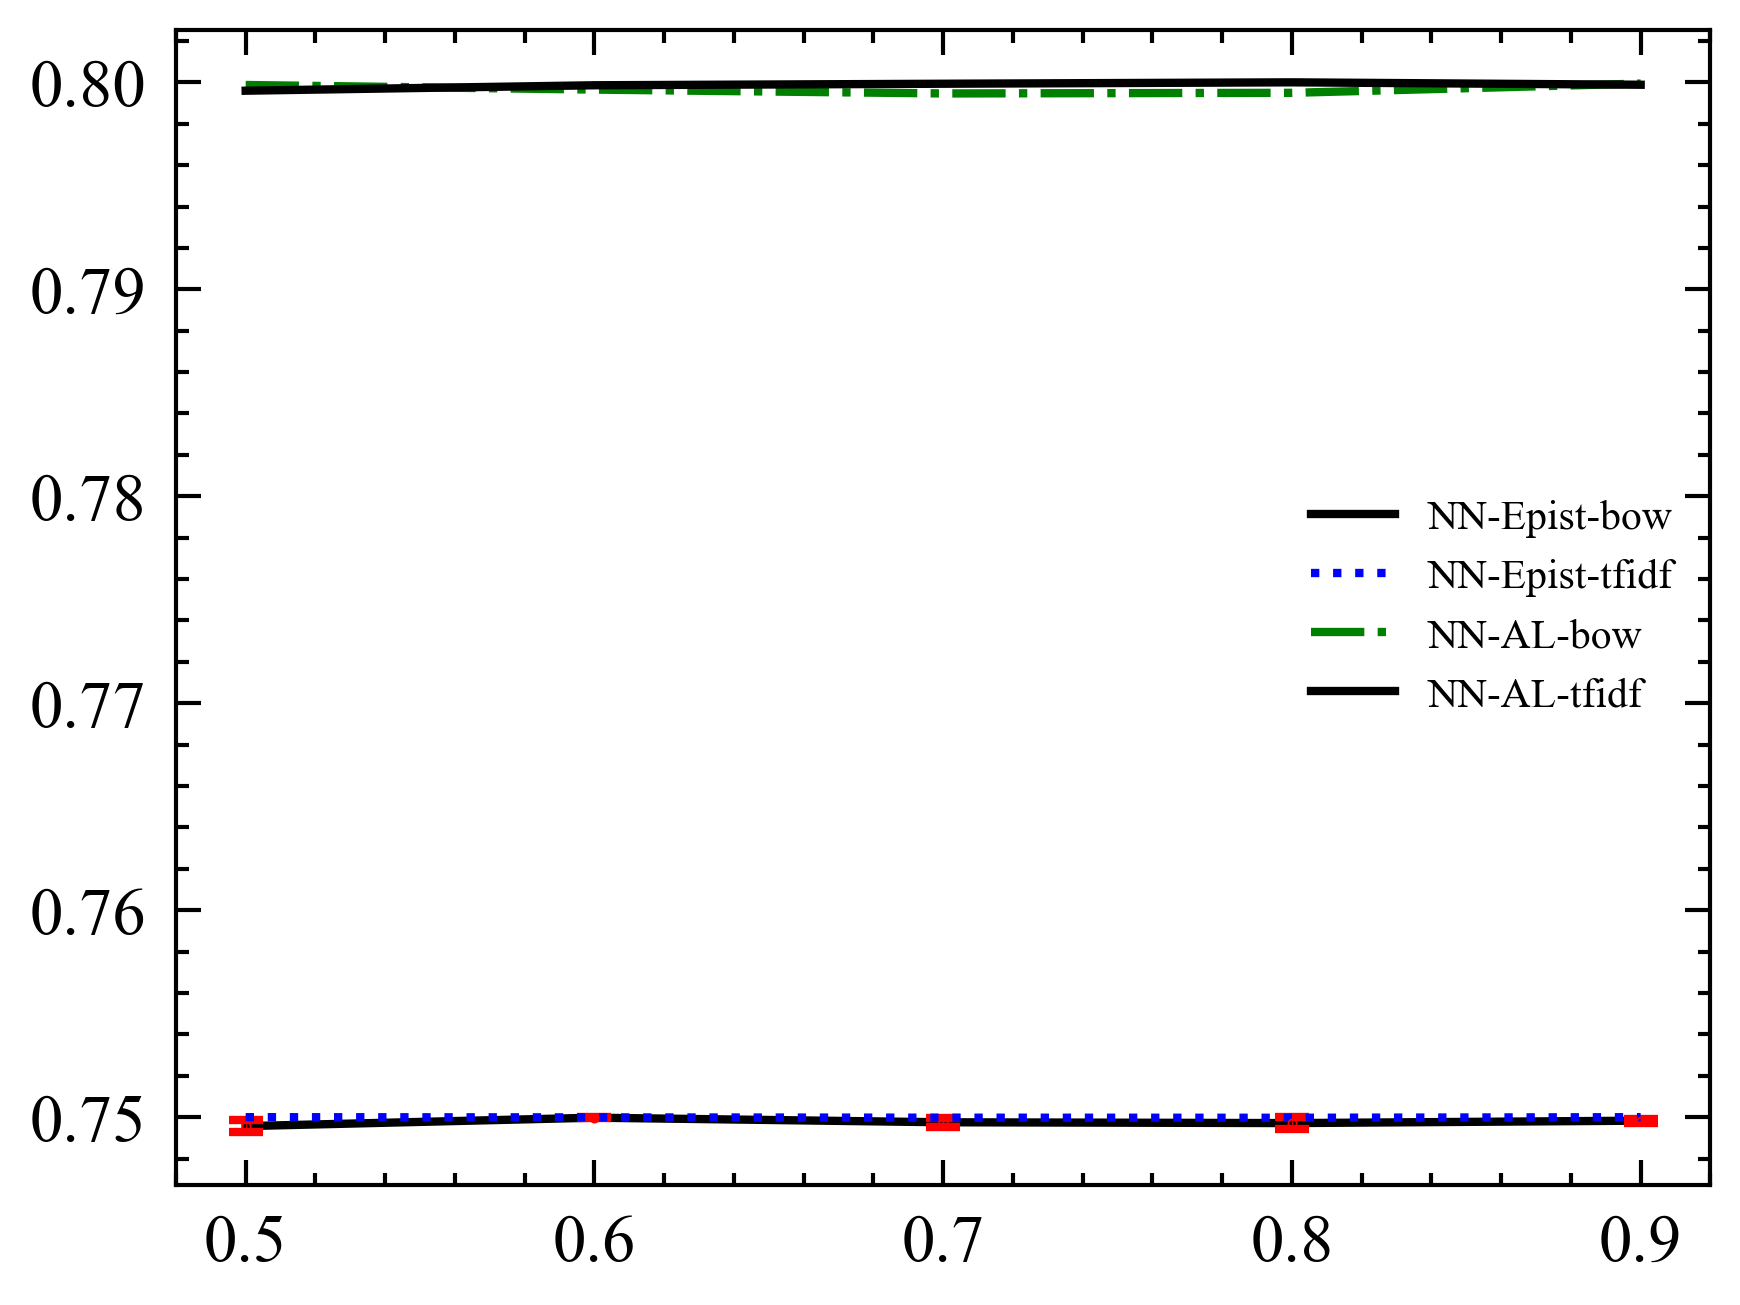

In [21]:
plt.plot(df_unpic_epist_bow_rl['trainsize'], df_unpic_epist_bow_rl['accuracy'], label = 'NN-Epist-bow')
plt.errorbar(df_unpic_epist_bow_rl['trainsize'], df_unpic_epist_bow_rl['accuracy'], yerr = df_unpic_epist_bow_rl['sem'], fmt = 'o',  markersize=0.2, capsize=2, elinewidth=0.1)
plt.plot(df_unpic_epist_tf_rl['trainsize'],df_unpic_epist_tf_rl['accuracy'], label = 'NN-Epist-tfidf')
#plt.errorbar(df_unpic_epist_tf_rl['trainsize'], df_unpic_epist_tf_rl['accuracy'], yerr = df_unpic_epist_tf_rl['sem'], markersize=0.2, capsize=2, elinewidth=0.1)
plt.plot(df_unpic_arg_bow_rl['trainsize'], df_unpic_arg_bow_rl['accuracy'], label = 'NN-AL-bow')
#plt.errorbar(df_unpic_arg_bow_rl['trainsize'], df_unpic_arg_bow_rl['accuracy'], yerr = df_unpic_arg_bow_rl['sem'], markersize=0.2, capsize=2, elinewidth=0.1)
plt.plot(df_unpic_arg_tfidf_al['trainsize'], df_unpic_arg_tfidf_al['accuracy'], label = 'NN-AL-tfidf')
#plt.errorbar(df_unpic_arg_tfidf_al['trainsize'],df_unpic_arg_tfidf_al['accuracy'], yerr = df_unpic_arg_tfidf_al['sem'], markersize=0.2, capsize=2, elinewidth=0.1)
plt.legend(prop={'size': 5})

# NEURAL NETWORK INVESTIGATIONS

In [14]:
def NN_invest(model1, input1, ephs, X_t, y_t, X_test, y_test, node1, node2, node3):
    maxlen = 100 
    model = model1
    model.add(layers.Dense(node1, input_dim = input, activation  = 'relu'))
    model.add(layers.Dense(node2, input_dim = input, activation  = 'relu'))
    model.add(layers.Dense(node3 ,activation = 'sigmoid'))
    model.add(layers.Flatten())
    model.compile(loss= 'binary_crossentropy', optimizer= 'adam', metrics= ['accuracy'])
    model.build(input1)
    model.summary()
    history = model.fit(X_t,y_t,epochs = ephs, verbose=True, validation_data=(X_test, y_test), batch_size=30 )
    return history



def NN_data_invest(X, y, tsize,  epoch_no, node1, node2, node3):
    X_train_b, X_test_b, y_train_b, y_test_b = train_test_split(X, y , train_size = tsize )
    input = X_train_b.shape[1] 
    nn1 = NN_invest(Sequential(), input, epoch_no, X_train_b, y_train_b, X_test_b, y_test_b, node1, node2, node3)
    return pd.DataFrame(nn1.history)

### 1. Changing the number of nodes

In [47]:
'''
node1: 12
node2: 8
node3: 1
'''
df_y1y2_bow_al = NN_data_invest(X_y1y2_bow_al,y_y1y2_bow_al , 0.8,  100, 12, 8, 1)


Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_26 (Dense)            (None, 12)                90768     
                                                                 
 dense_27 (Dense)            (None, 8)                 104       
                                                                 
 dense_28 (Dense)            (None, 1)                 9         
                                                                 
 flatten_8 (Flatten)         (None, 1)                 0         
                                                                 
Total params: 90,881
Trainable params: 90,881
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
5/5 [==============================] - 1s 55ms/step - loss: 0.5539 - accuracy: 0.7958 - val_loss: 0.5298 - val_accuracy: 0.8000
Epoch 2/100
5/5 [========================

In [17]:

#df_pickle_y1y2_bow_al = utils.save_as_pickle_file(df_y1y2_bow_al,'NN_investigations_y1y2_1000ephs_12_8_1', dir_name_e)
df_unpickle_y1y2_bow_al = utils.load_pickle_file_to_df('NN_investigations_y1y2_1000ephs_12_8_1', dir_name_e)


<AxesSubplot: >

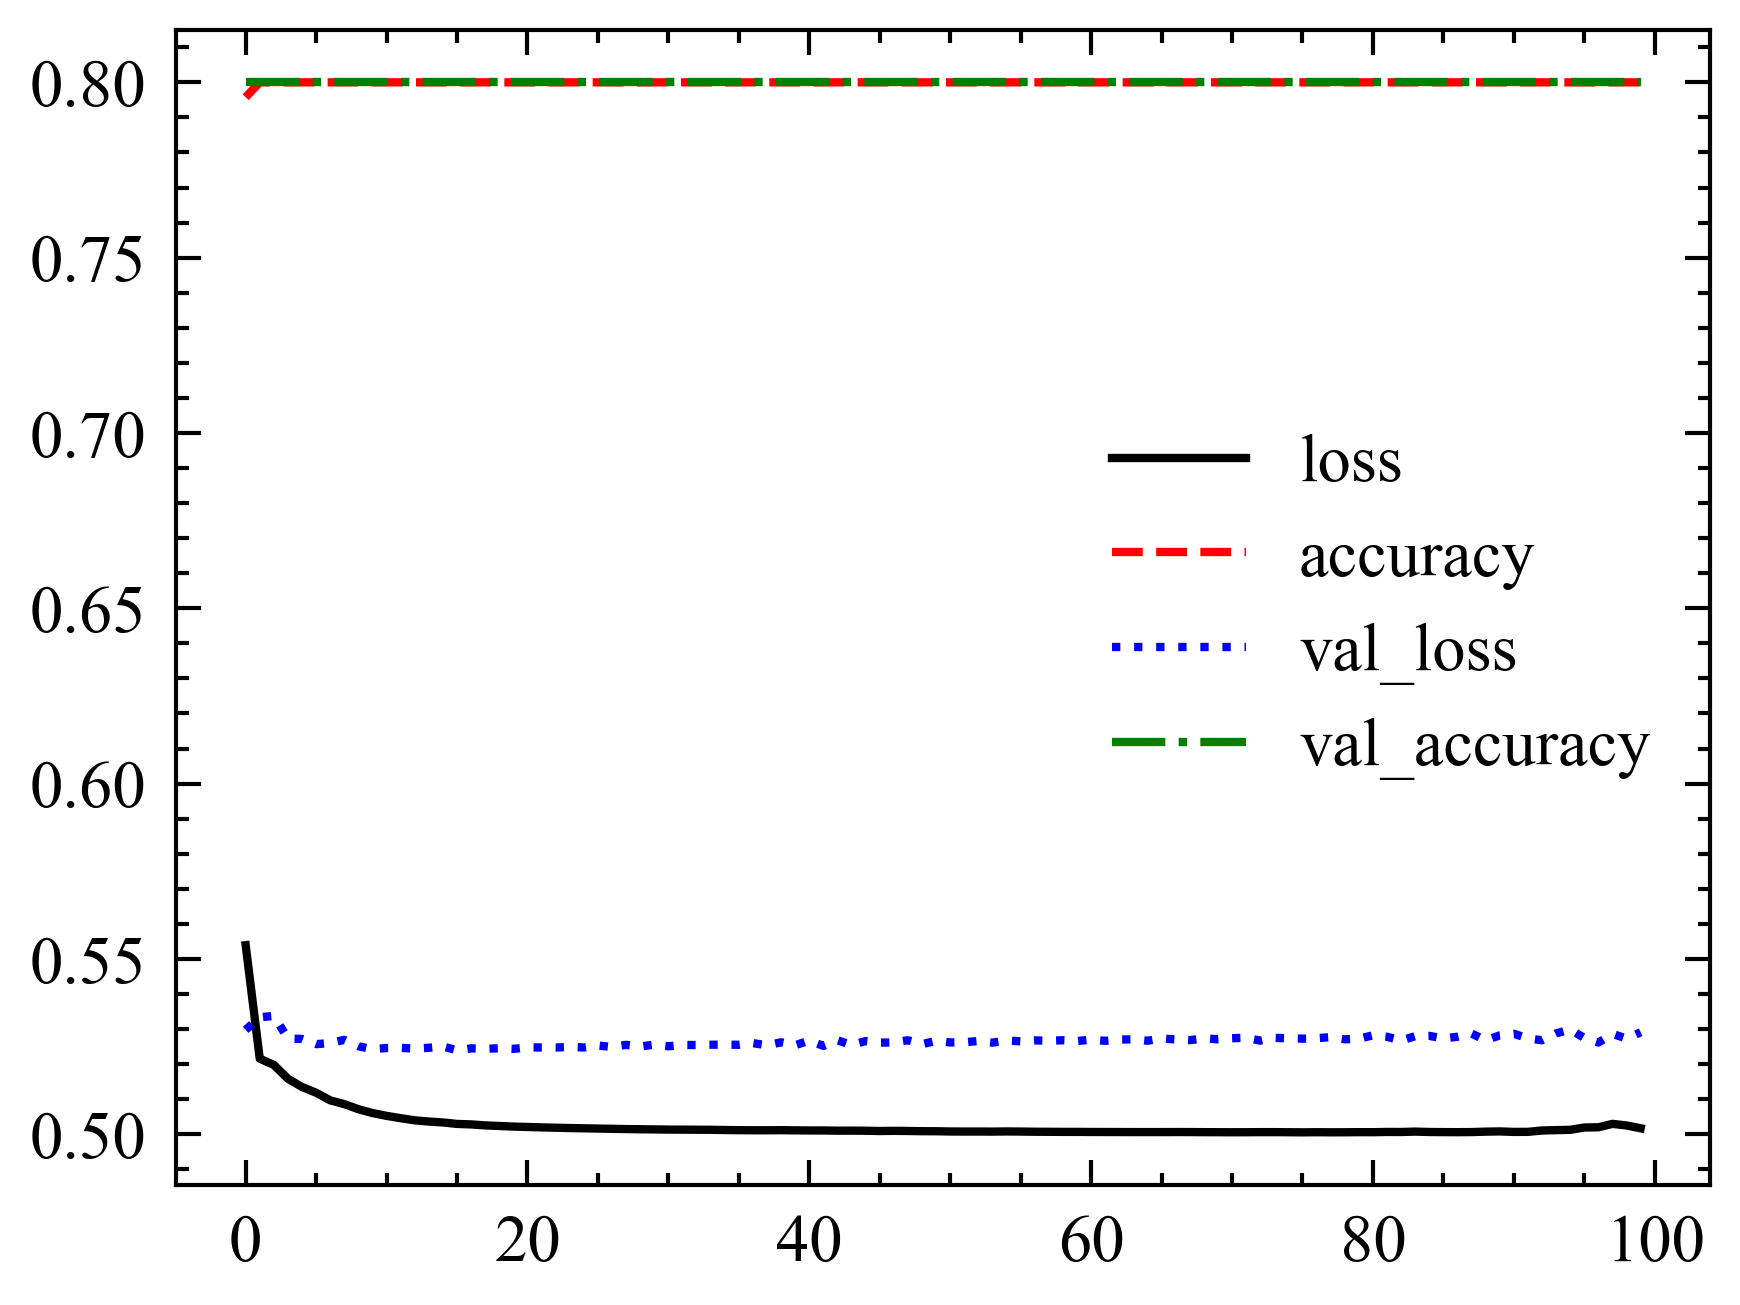

In [18]:
# Standard neural network plot of loss, val_loss, 
df_unpickle_y1y2_bow_al.plot( kind = 'line')

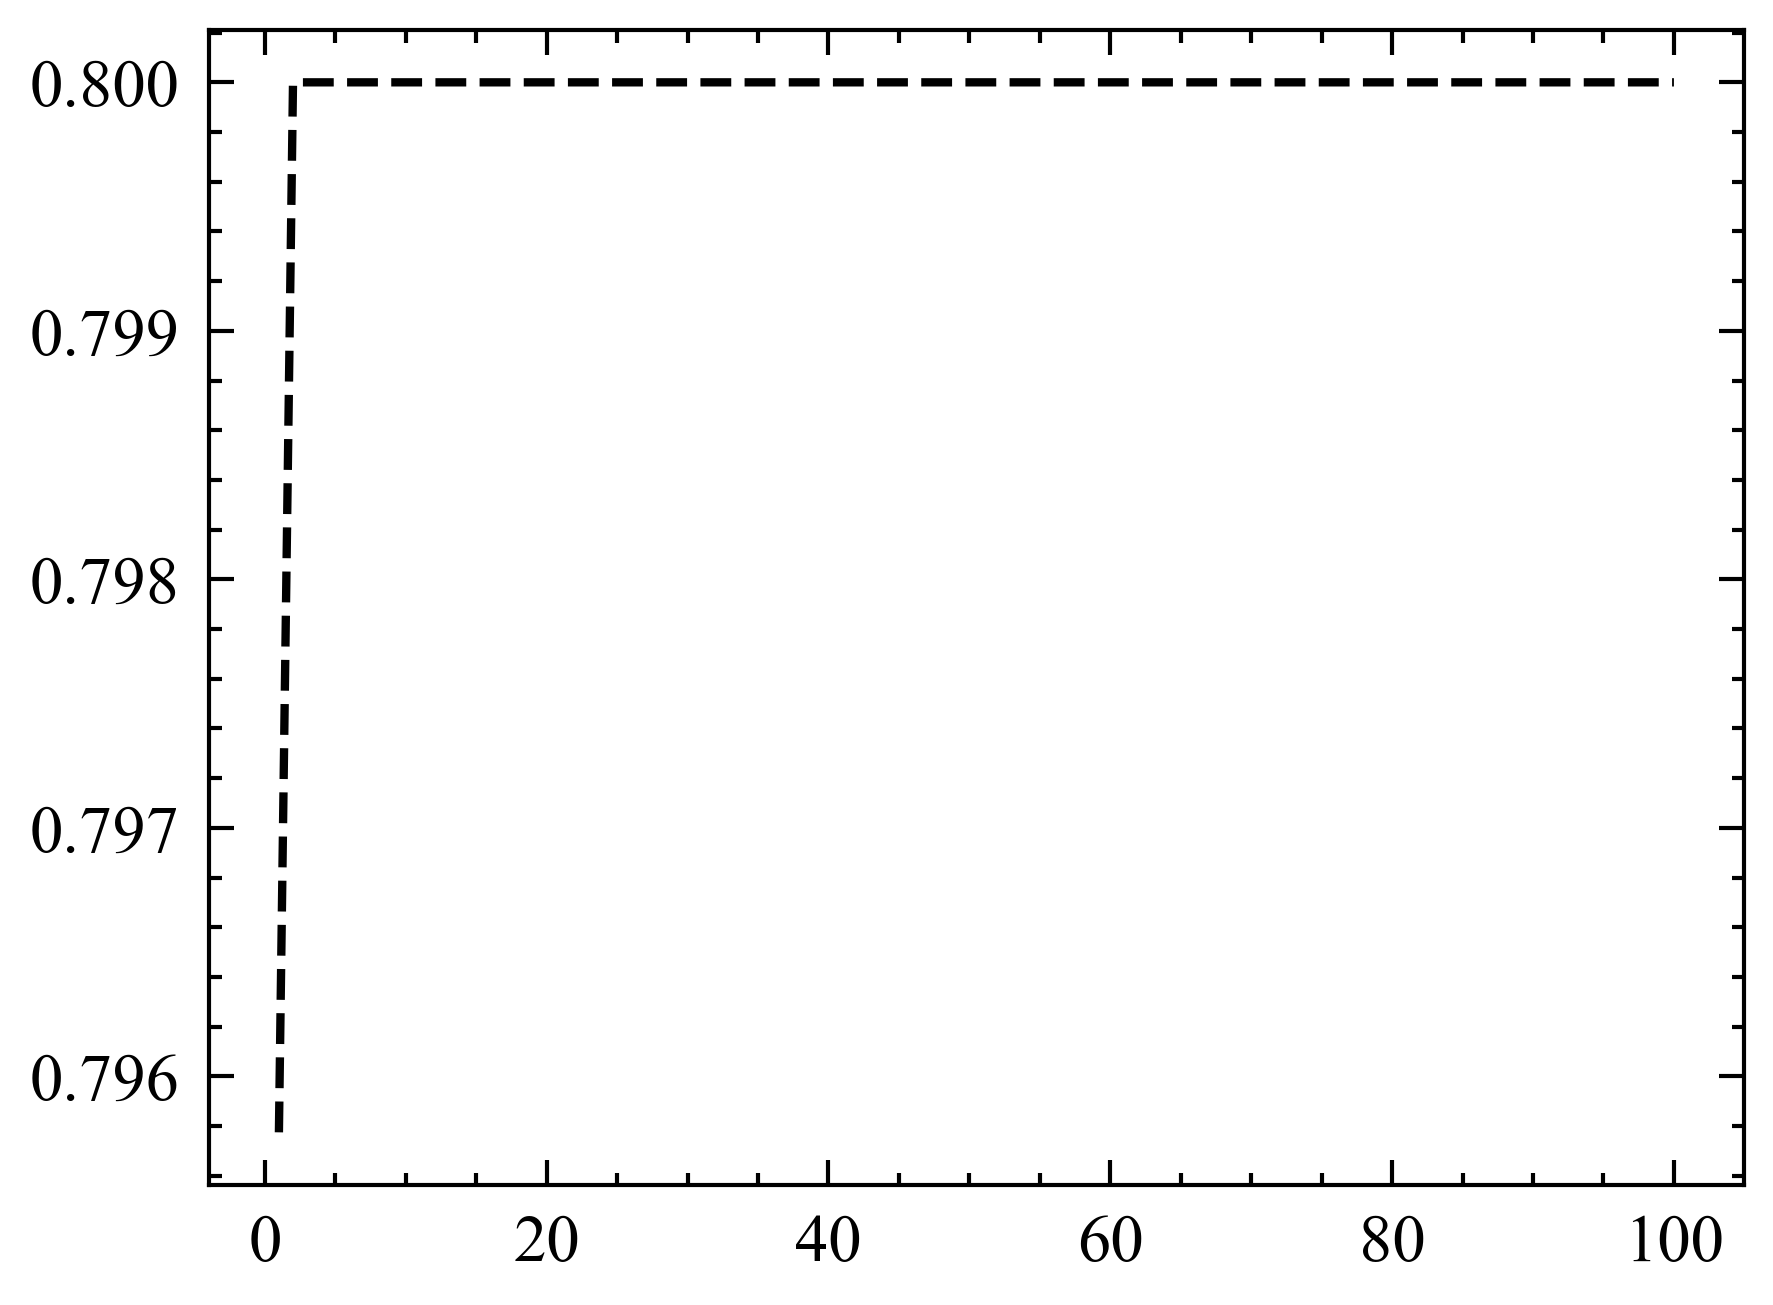

In [53]:
y1y2_bow_al_arr = []
x               = np.linspace(1,100,100)
for i in df_unpickle_y1y2_bow_al['accuracy']:
    y1y2_bow_al_arr.append(i)
plt.plot(x,y1y2_bow_al_arr , '--')

In [55]:
df_y1y2_bow_al2 = NN_data_invest(X_y1y2_bow_al,y_y1y2_bow_al , 0.8, 100, 150,100, 1)
#df_pickle_y1y2_bow_al2 = utils.save_as_pickle_file(df_y1y2_bow_al2,'NN_investigations_y1y2_1000ephs_150_100_1', dir_name_e)

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_32 (Dense)            (None, 150)               1134600   
                                                                 
 dense_33 (Dense)            (None, 100)               15100     
                                                                 
 dense_34 (Dense)            (None, 1)                 101       
                                                                 
 flatten_10 (Flatten)        (None, 1)                 0         
                                                                 
Total params: 1,149,801
Trainable params: 1,149,801
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
5/5 [==============================] - 3s 68ms/step - loss: 1.6713 - accuracy: 0.6732 - val_loss: 0.5723 - val_accuracy: 0.8000
Epoch 2/100
5/5 [==================

In [19]:
df_unpickle_y1y2_bow_al2= utils.load_pickle_file_to_df('NN_investigations_y1y2_1000ephs_5012_100_1', dir_name_e)

# y1y2_bow_al2_arr = []
# x = np.linspace(1,100,100)

# for i in df_y1y2_bow_al2['accuracy']:
#     y1y2_bow_al2_arr.append(i)

In [54]:
# input dimension  = 7518
# neuron number is 2/3 
df_y1y2_bow_al3 = NN_data_invest(X_y1y2_bow_al,y_y1y2_bow_al , 0.8, 100, 5012,100, 1)
df_pickle_y1y2_bow_al3 = utils.save_as_pickle_file(df_y1y2_bow_al3,'NN_investigations_y1y2_1000ephs_5012_100_1', dir_name_e)





Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_29 (Dense)            (None, 5012)              37910768  
                                                                 
 dense_30 (Dense)            (None, 100)               501300    
                                                                 
 dense_31 (Dense)            (None, 1)                 101       
                                                                 
 flatten_9 (Flatten)         (None, 1)                 0         
                                                                 
Total params: 38,412,169
Trainable params: 38,412,169
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
5/5 [==============================] - 2s 309ms/step - loss: 9.9212 - accuracy: 0.3268 - val_loss: 12.1994 - val_accuracy: 0.2000
Epoch 2/100
5/5 [==============

In [21]:
df_unpickle_y1y2_bow_al3= utils.load_pickle_file_to_df('NN_investigations_y1y2_1000ephs_5012_100_1', dir_name_e)
# y1y2_bow_al3_arr = []
# x = np.linspace(1,100,100)

# for i in df_y1y2_bow_al3['accuracy']:
#     y1y2_bow_al3_arr.append(i)
# print(df_y1y2_bow_al3['val_loss'])

In [57]:
# input dimension  = 7518
# neuron number is 2/3 
df_y1y2_bow_al4 = NN_data_invest(X_y1y2_bow_al,y_y1y2_bow_al , 0.8, 100, 5012,2500, 1)
df_pickle_y1y2_bow_al4 = utils.save_as_pickle_file(df_y1y2_bow_al4,'NN_investigations_y1y2_1000ephs_5012_2500_1', dir_name_e)


Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_35 (Dense)            (None, 5012)              37910768  
                                                                 
 dense_36 (Dense)            (None, 2500)              12532500  
                                                                 
 dense_37 (Dense)            (None, 1)                 2501      
                                                                 
 flatten_11 (Flatten)        (None, 1)                 0         
                                                                 
Total params: 50,445,769
Trainable params: 50,445,769
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
5/5 [==============================] - 3s 323ms/step - loss: 9.7800 - accuracy: 0.3268 - val_loss: 12.1994 - val_accuracy: 0.2000
Epoch 2/100
5/5 [==============

In [22]:
df_unpickle_y1y2_bow_al4= utils.load_pickle_file_to_df('NN_investigations_y1y2_1000ephs_5012_2500_1', dir_name_e)

# y1y2_bow_al4_arr = []
# x = np.linspace(1,100,100)

# for i in df_y1y2_bow_al4['accuracy']:
#     y1y2_bow_al4_arr.append(i)

### Accuracy and loss graphs for  different number of neurons 


Text(0.5, 1.0, ' 0.8 ratio ;100ephs; BOW - Argument Level, ')

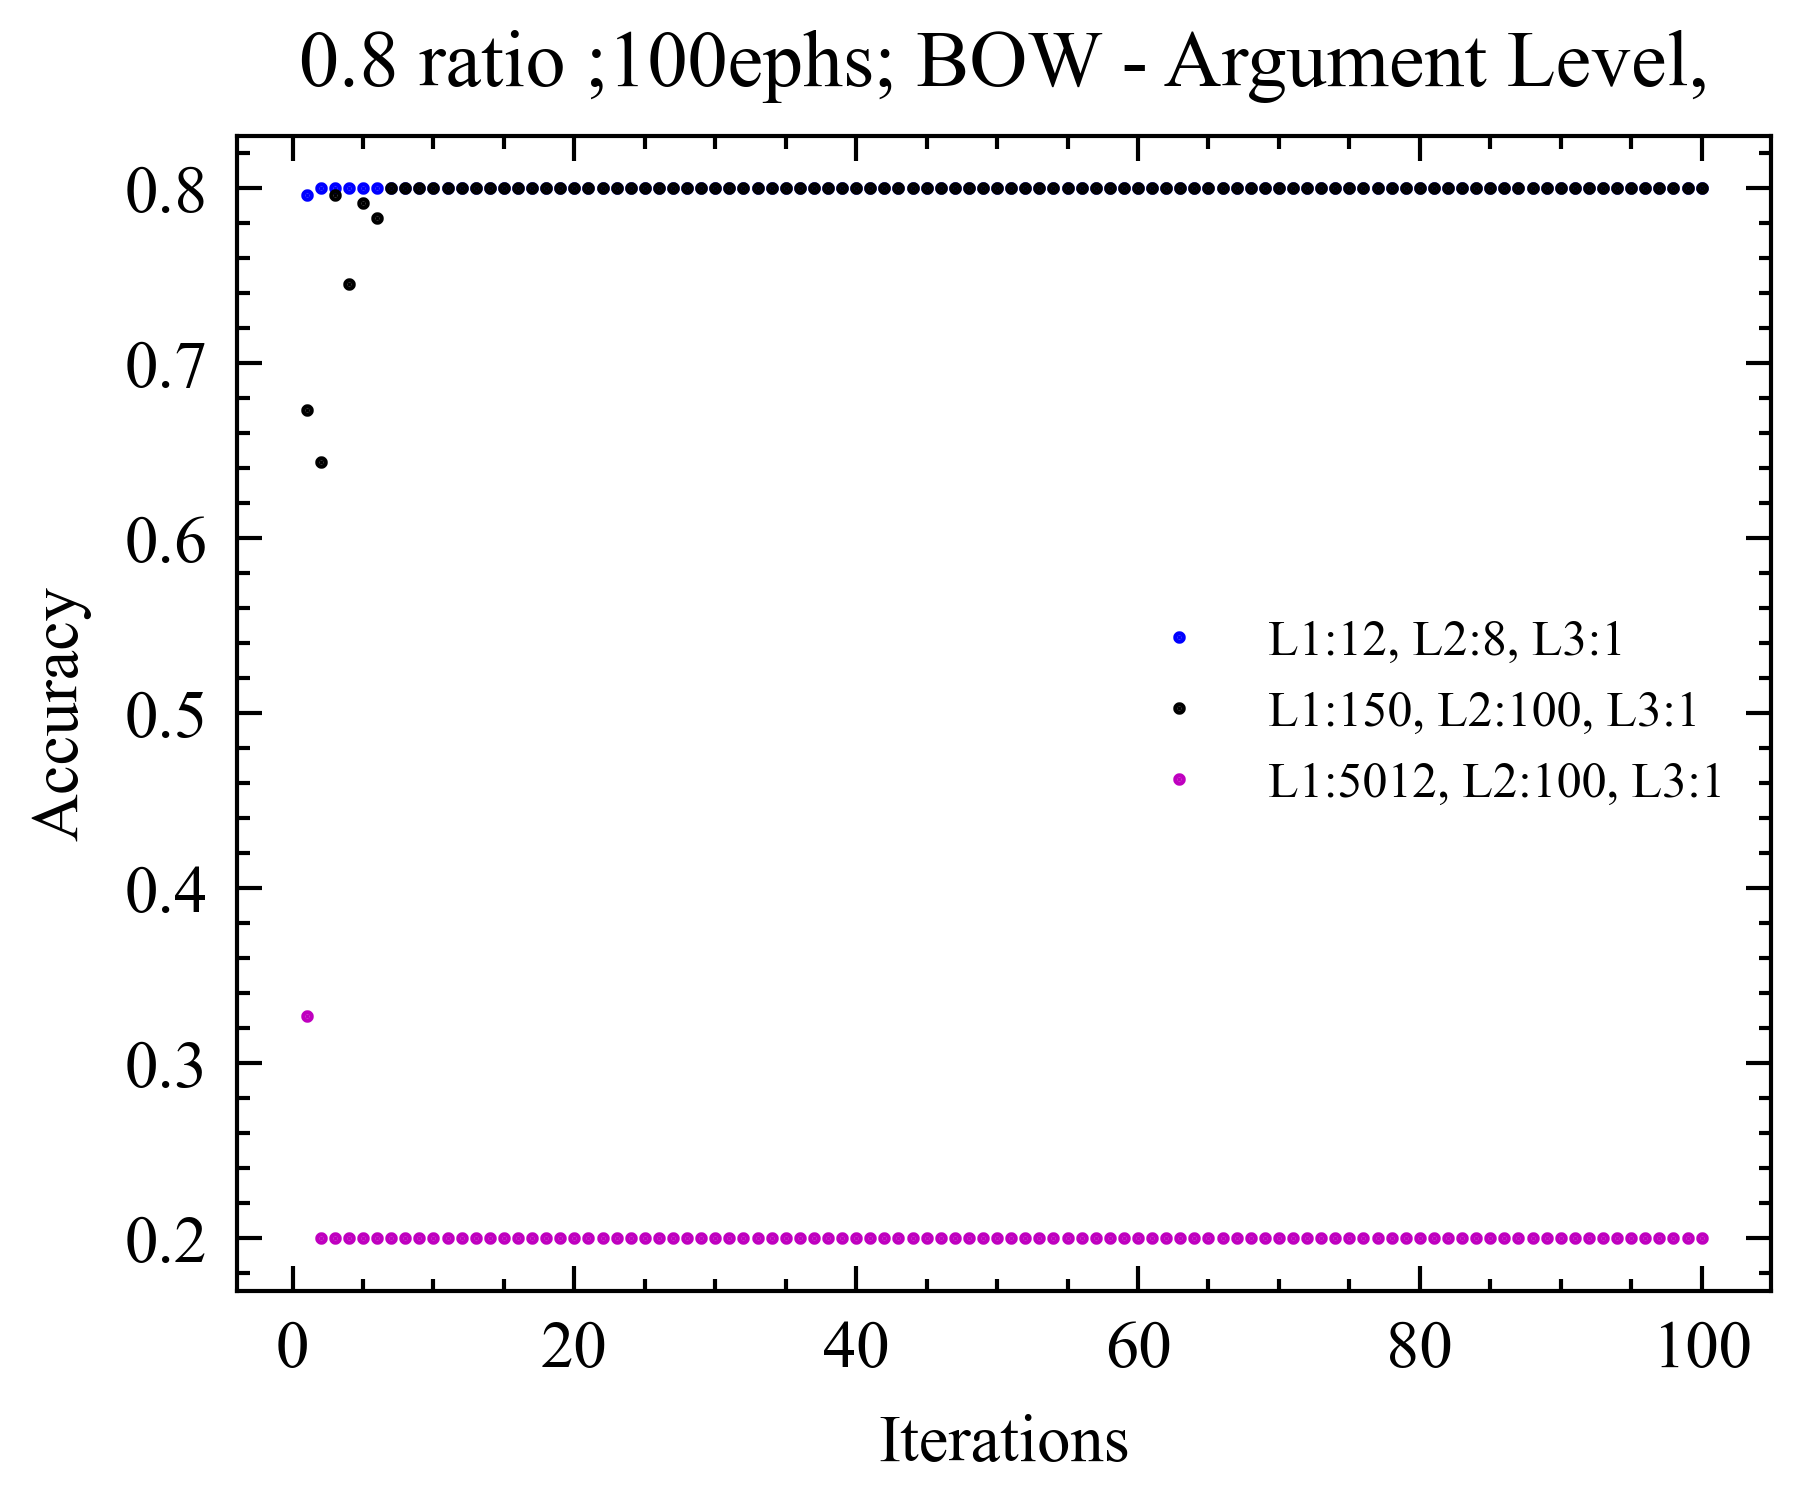

In [71]:
plt.plot(x,y1y2_bow_al_arr , 'o', label = 'L1:12, L2:8, L3:1', c = 'b', markersize = 0.5)
plt.plot(x,y1y2_bow_al2_arr, 'o', label = 'L1:150, L2:100, L3:1', markersize = 0.5)
plt.plot(x, y1y2_bow_al3_arr , 'o', label = 'L1:5012, L2:100, L3:1', c = 'm', markersize = 0.5)
plt.ylabel('Accuracy')
plt.xlabel('Iterations')
plt.legend( prop = {'size':6})
plt.title(' 0.8 ratio ;100ephs; BOW - Argument Level, ')

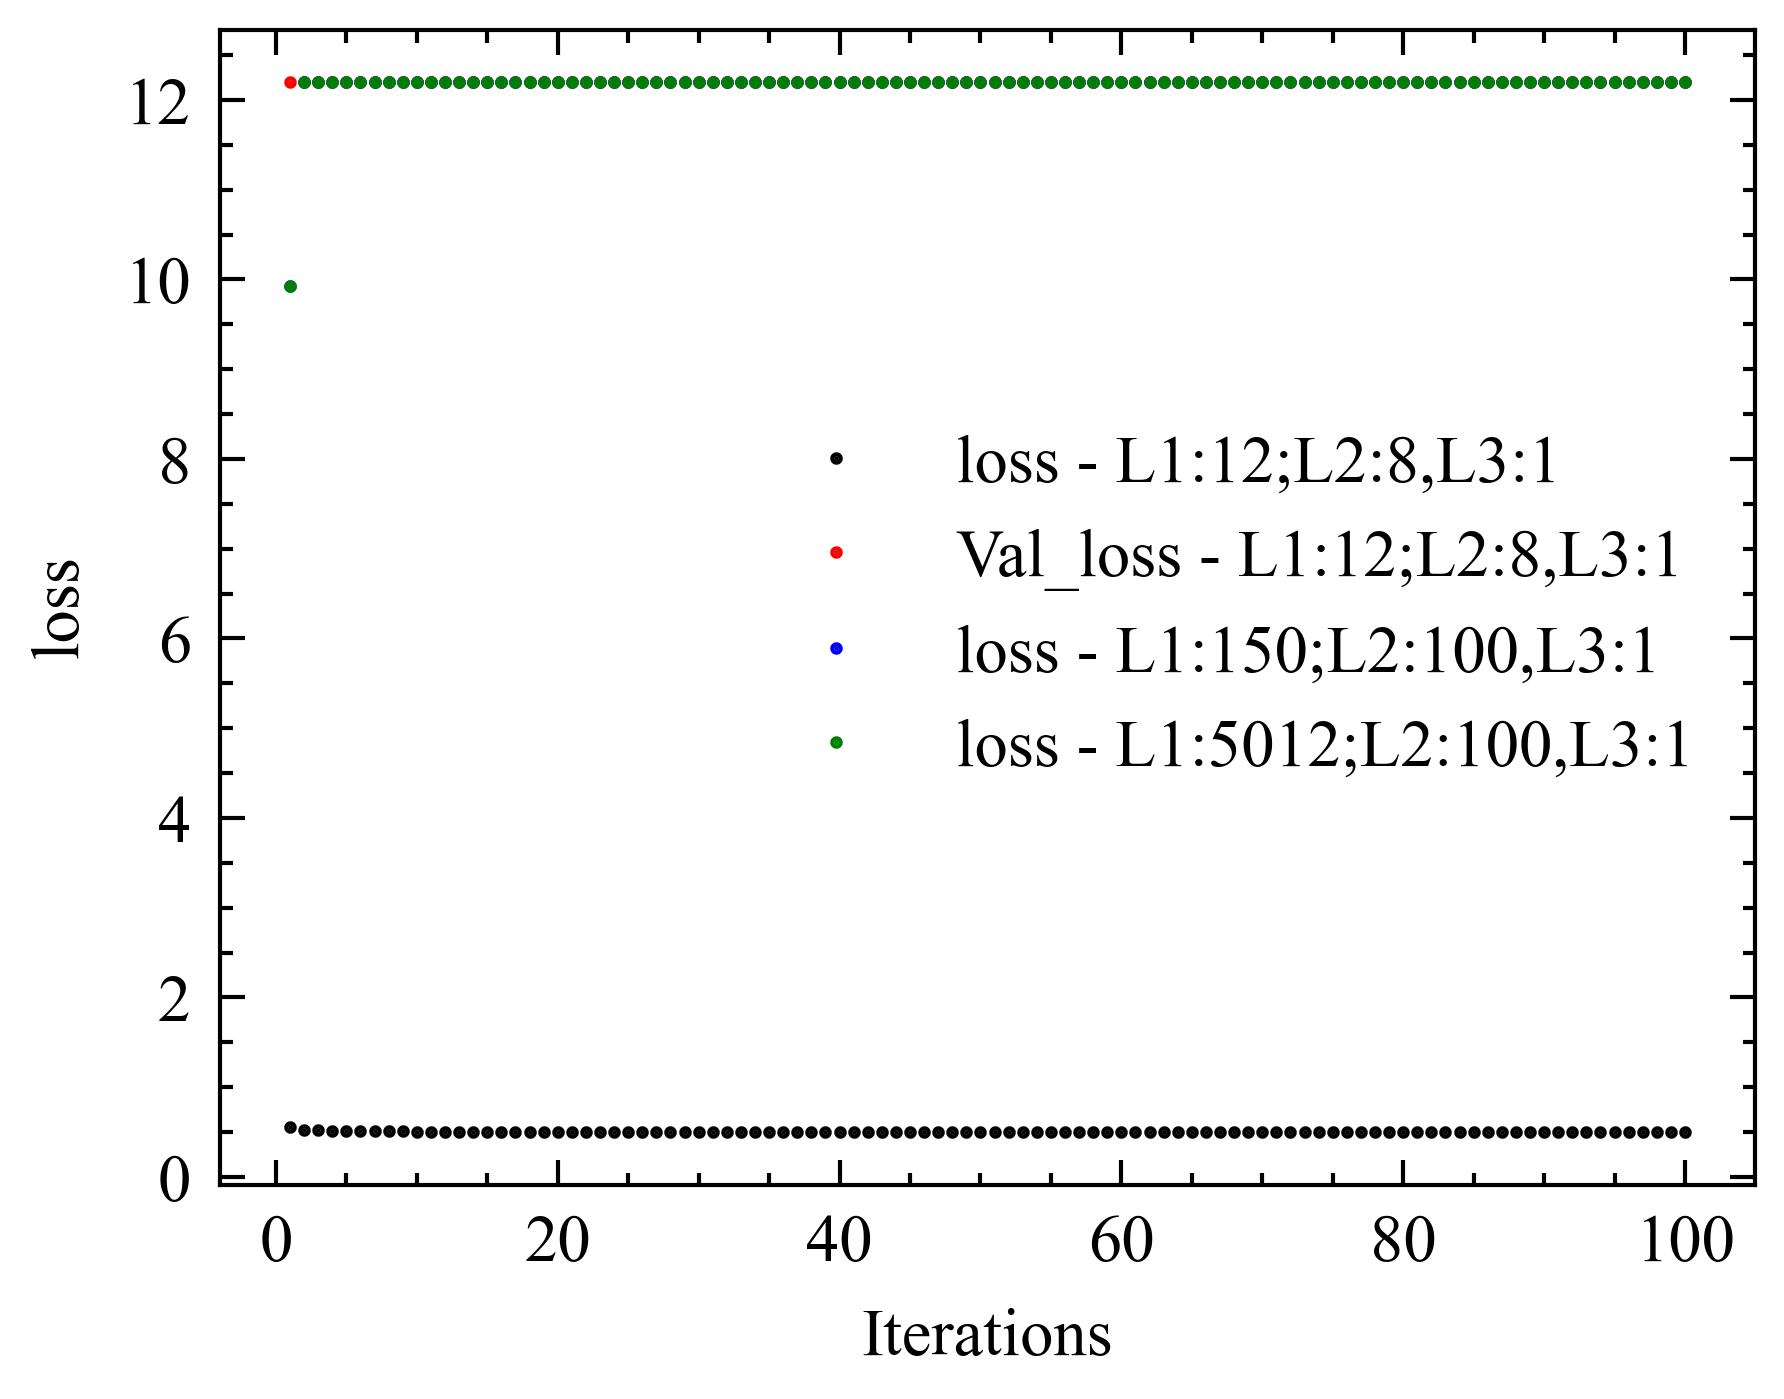

In [25]:
plt.plot(x, df_unpickle_y1y2_bow_al['loss'], 'o', label = 'loss - L1:12;L2:8,L3:1', markersize = 0.5)
plt.plot(x, df_unpickle_y1y2_bow_al2['val_loss'], 'o', label = 'Val_loss - L1:12;L2:8,L3:1', markersize = 0.5)
plt.plot(x, df_unpickle_y1y2_bow_al2['loss'], 'o', label = 'loss - L1:150;L2:100,L3:1', markersize = 0.5)
plt.plot(x, df_unpickle_y1y2_bow_al3['loss'], 'o', label = 'loss - L1:5012;L2:100,L3:1', markersize = 0.5)
#plt.plot(x, df_unpickle_y1y2_bow_al4['loss'], 'o', label = 'loss - L1:5012;L2:2500,L3:1')
plt.legend()
plt.ylabel('loss')
plt.xlabel('Iterations')
plt.show()

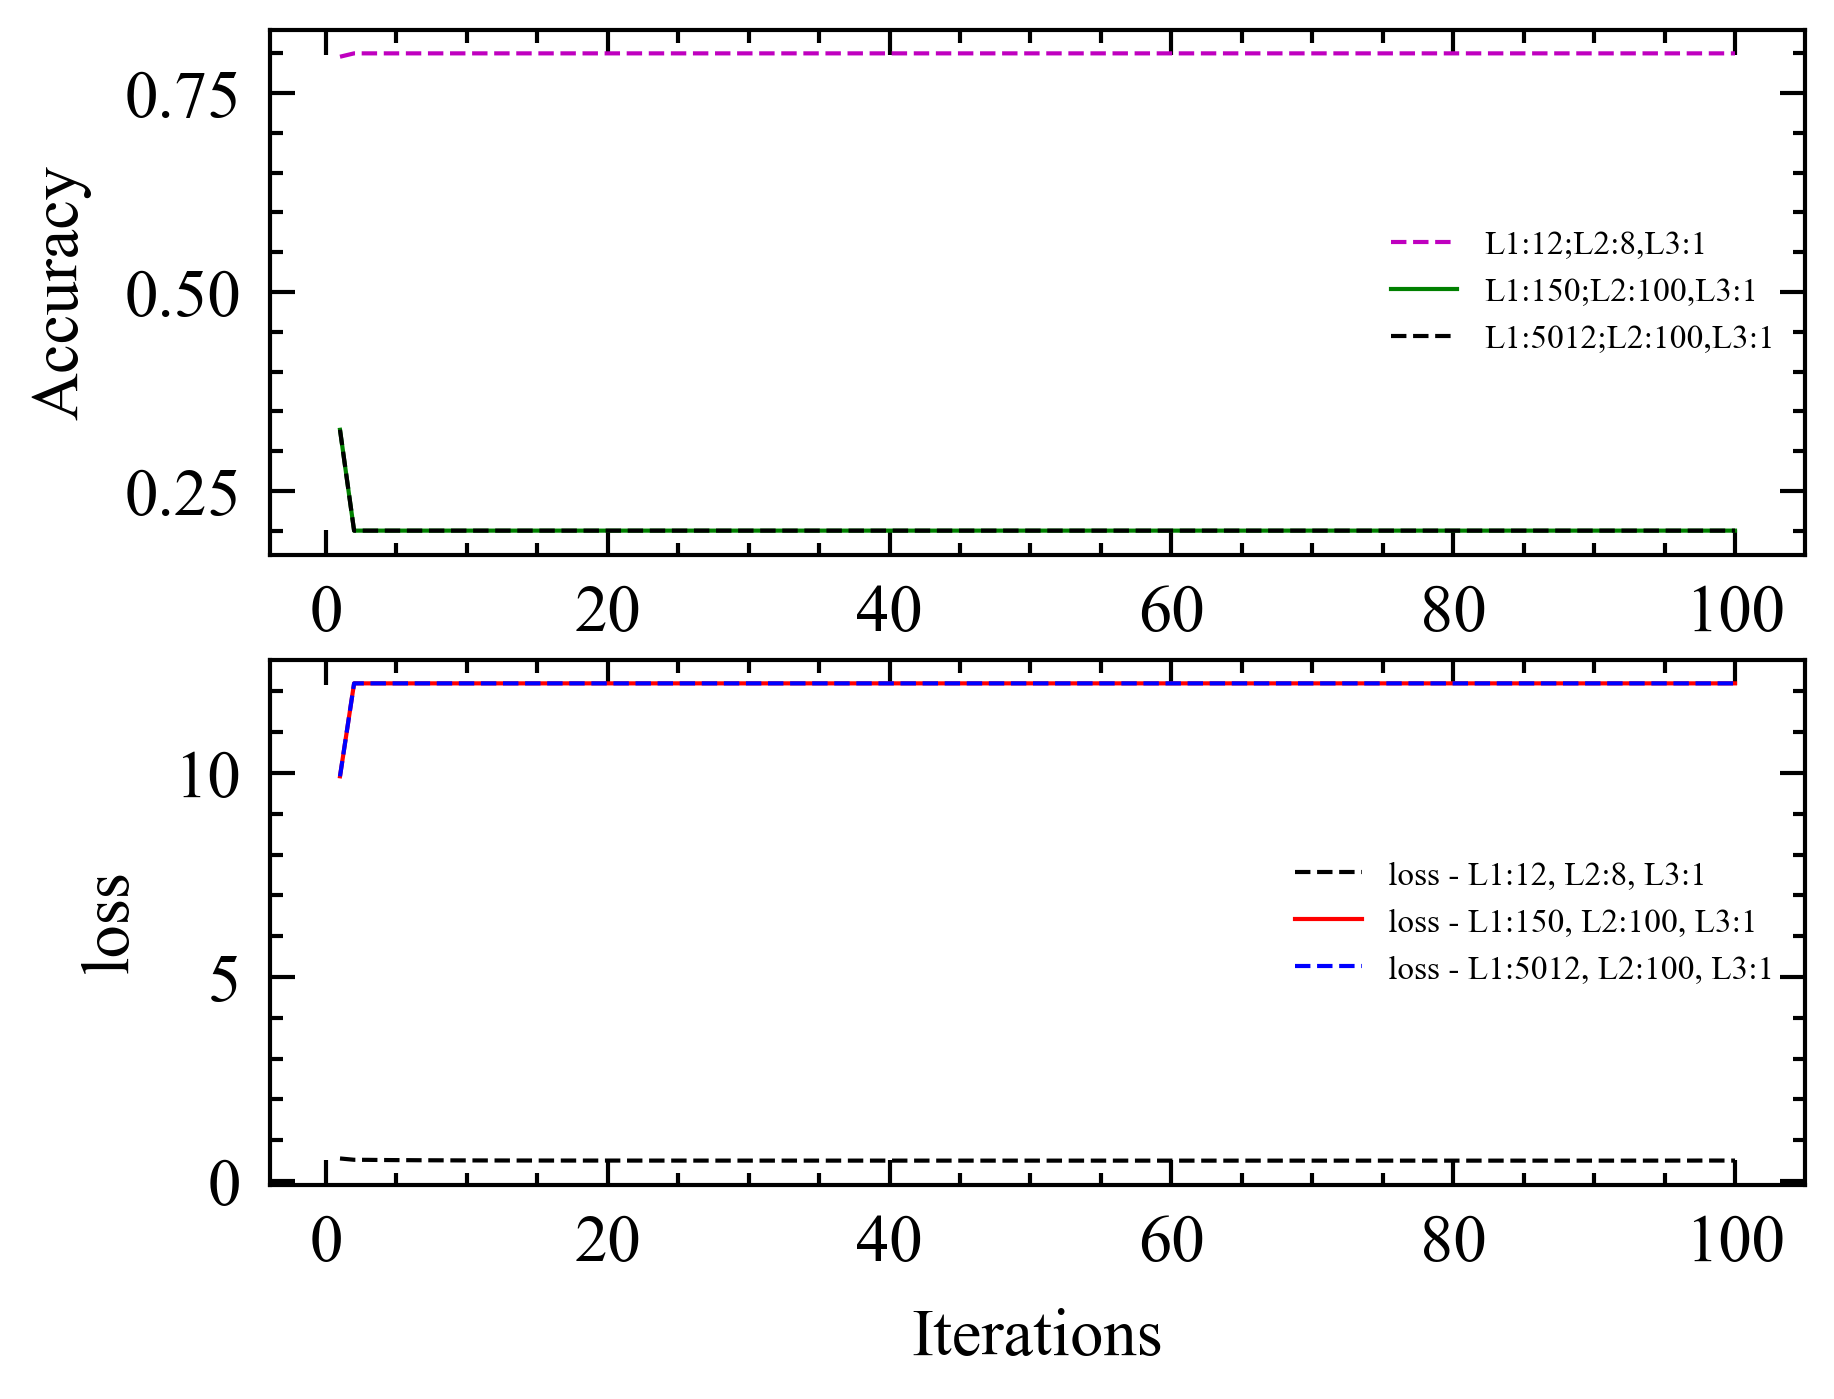

In [67]:
# Subplots of accuracy and loss graphs 
fig = plt.figure()
plt.subplot(2,1,1)
plt.plot(x, df_unpickle_y1y2_bow_al['accuracy'], '--', label = 'L1:12;L2:8,L3:1', linewidth = 0.5, c = 'm')
plt.plot(x, df_unpickle_y1y2_bow_al2['accuracy'], '-', label = 'L1:150;L2:100,L3:1', linewidth = 0.5, c = 'g')
plt.plot(x, df_unpickle_y1y2_bow_al3['accuracy'], '--', label = 'L1:5012;L2:100,L3:1', linewidth = 0.5)
plt.ylabel('Accuracy')
plt.xlabel('Iterations')
plt.legend( prop = {'size':4})

plt.subplot(2,1,2)
plt.plot(x, df_unpickle_y1y2_bow_al['loss'], '--', label = 'loss - L1:12, L2:8, L3:1', linewidth = 0.5)
plt.plot(x, df_unpickle_y1y2_bow_al2['loss'], '-', label = 'loss - L1:150, L2:100, L3:1', linewidth = 0.5)
plt.plot(x, df_unpickle_y1y2_bow_al3['loss'], '--', label = 'loss - L1:5012, L2:100, L3:1', linewidth = 0.5)

plt.legend(prop = {'size':4})
plt.ylabel('loss')
plt.xlabel('Iterations')

plt.show()


### 2. Finding the best Optimizer function (100 and 500 epochs)

In [28]:
def NN_opt(model1, input1, ephs, X_t, y_t, X_test, y_test, node1, node2, node3, opt):
    maxlen = 100 
    model = model1
    model.add(layers.Dense(node1, input_dim = input, activation  = 'relu'))
    model.add(layers.Dense(node2, input_dim = input, activation  = 'relu'))
    #model.add(layers.Dense(node2, input_dim = input, activation  = 'relu'))
    model.add(layers.Dense(node3 ,activation = 'sigmoid'))
    model.add(layers.Flatten())
    model.compile(loss= 'binary_crossentropy', optimizer= opt, metrics= ['accuracy'])
    model.build(input1)
    model.summary()
    history = model.fit(X_t,y_t,epochs = ephs, verbose=True, validation_data=(X_test, y_test), batch_size=30 )
    return history


optimizers = ['Adadelta', 'Adagrad', 'Adam', 'RMSprop', 'SGD']
def NN_data_opt(X, y, tsize, epoch_no, node1, node2, node3, opt):
    accuracy = []
    loss     = []
    val_loss = []
    for i in opt:
        X_train_b, X_test_b, y_train_b, y_test_b = train_test_split(X, y , train_size = tsize)
        input = X_train_b.shape[1] 
        nn1 = NN_opt(Sequential(), input, epoch_no, X_train_b, y_train_b, X_test_b, y_test_b, node1, node2, node3, i)
        accuracy.append(nn1.history['accuracy'])
        loss.append(nn1.history['loss'])
        val_loss.append(nn1.history['val_loss'])
    dictionary = {'accuracy':accuracy, 'loss': loss, 'val_loss':val_loss}
    df = pd.DataFrame(dictionary)
    return df

In [29]:
df_bow_al_opt = NN_data_opt(X_y1y2_bow_al, y_y1y2_bow_al,0.8,100, 12,8,1,optimizers)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 12)                90768     
                                                                 
 dense_1 (Dense)             (None, 8)                 104       
                                                                 
 dense_2 (Dense)             (None, 1)                 9         
                                                                 
 flatten (Flatten)           (None, 1)                 0         
                                                                 
Total params: 90,881
Trainable params: 90,881
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
5/5 [==============================] - 2s 150ms/step - loss: 0.9706 - accuracy: 0.8000 - val_loss: 0.9617 - val_accuracy: 0.8000
Epoch 2/100
5/5 [==========================

In [30]:
df_bow_al_opt['Optimizers'] = optimizers
df_pickle_al_bow_opt = utils.save_as_pickle_file(df_bow_al_opt,'NN_investigations_y1y2_1000epochs_Optimizer', dir_name_e)

In [32]:
df_unpickle_al_bow_opt = utils.load_pickle_file_to_df('NN_investigations_y1y2_1000epochs_Optimizer', dir_name_e)
print(df_unpickle_al_bow_opt)

                                            accuracy  \
0  [0.8000000715255737, 0.8000000715255737, 0.800...   
1  [0.44507041573524475, 0.753521203994751, 0.791...   
2  [0.7788732647895813, 0.7830986380577087, 0.800...   
3  [0.6732394695281982, 0.8000000715255737, 0.800...   
4  [0.6098591685295105, 0.7830986380577087, 0.800...   

                                                loss  \
0  [0.9705873131752014, 0.9677411913871765, 0.964...   
1  [1.9129105806350708, 0.569555401802063, 0.5452...   
2  [0.6658298969268799, 0.554868757724762, 0.5336...   
3  [0.6477512717247009, 0.5222792625427246, 0.516...   
4  [3.2894058227539062, 0.7853254675865173, 0.520...   

                                            val_loss Optimizers  
0  [0.9616631269454956, 0.9588910341262817, 0.956...   Adadelta  
1  [0.6447192430496216, 0.566993772983551, 0.5529...    Adagrad  
2  [0.5660064220428467, 0.5435225963592529, 0.533...       Adam  
3  [0.5310961604118347, 0.5210422873497009, 0.523...    RMSpro

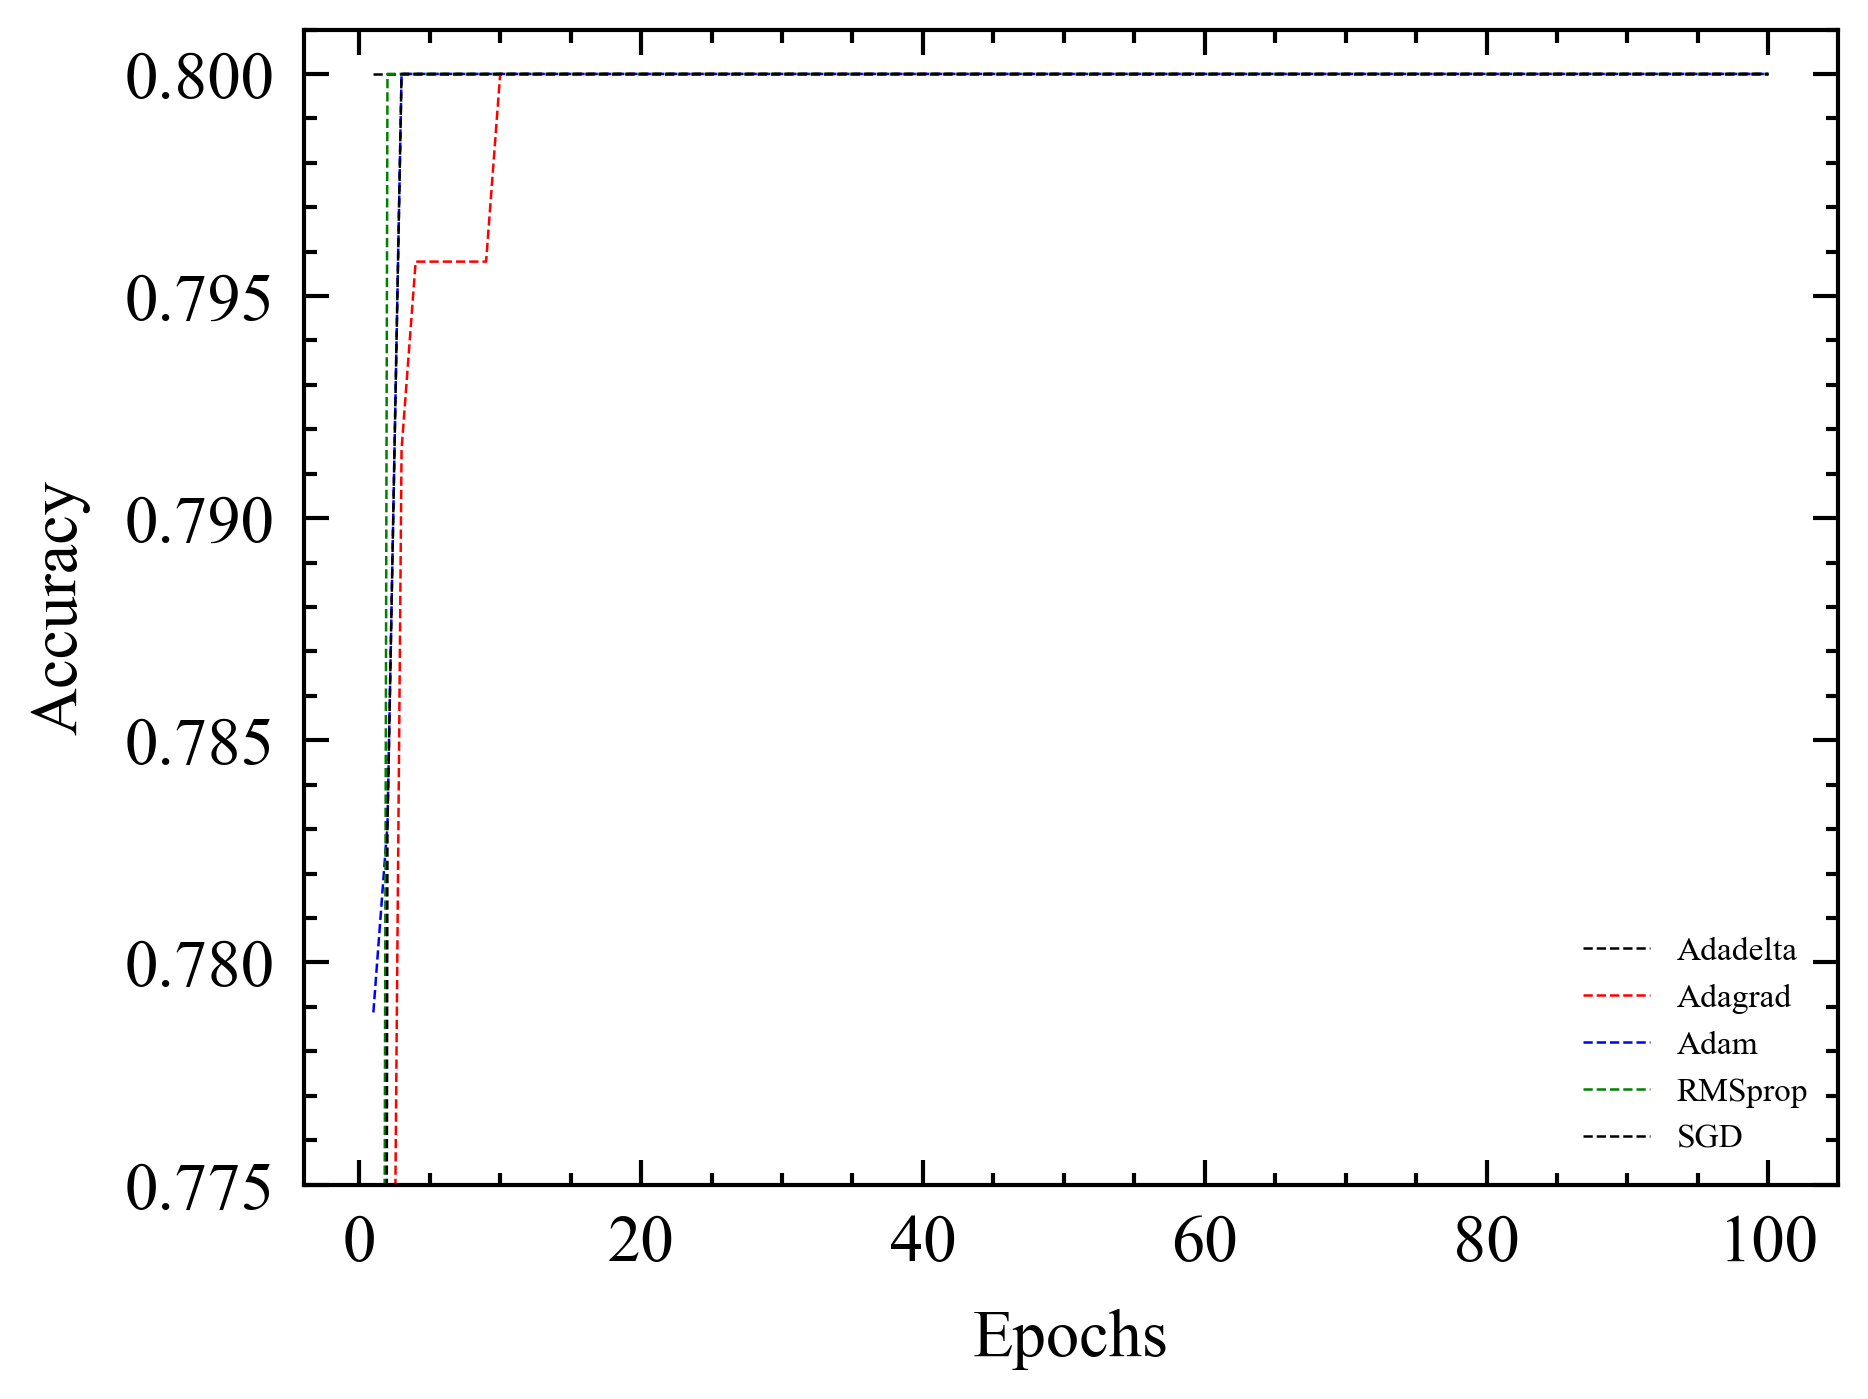

In [52]:
plt.plot(x, df_unpickle_al_bow_opt['accuracy'][0], '--', label = 'Adadelta', linewidth = 0.3)
plt.plot(x, df_unpickle_al_bow_opt['accuracy'][1], '--', label = 'Adagrad',  linewidth = 0.3)
plt.plot(x, df_unpickle_al_bow_opt['accuracy'][2], '--', label = 'Adam',  linewidth = 0.3)
plt.plot(x, df_unpickle_al_bow_opt['accuracy'][3], '--', label = 'RMSprop', linewidth = 0.3)
plt.plot(x, df_unpickle_al_bow_opt['accuracy'][4], '--', label = 'SGD',  linewidth = 0.3)
plt.legend(prop = {'size':4})
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.ylim(0.775, 0.801)
plt.show()

Text(0, 0.5, 'Accuracy')

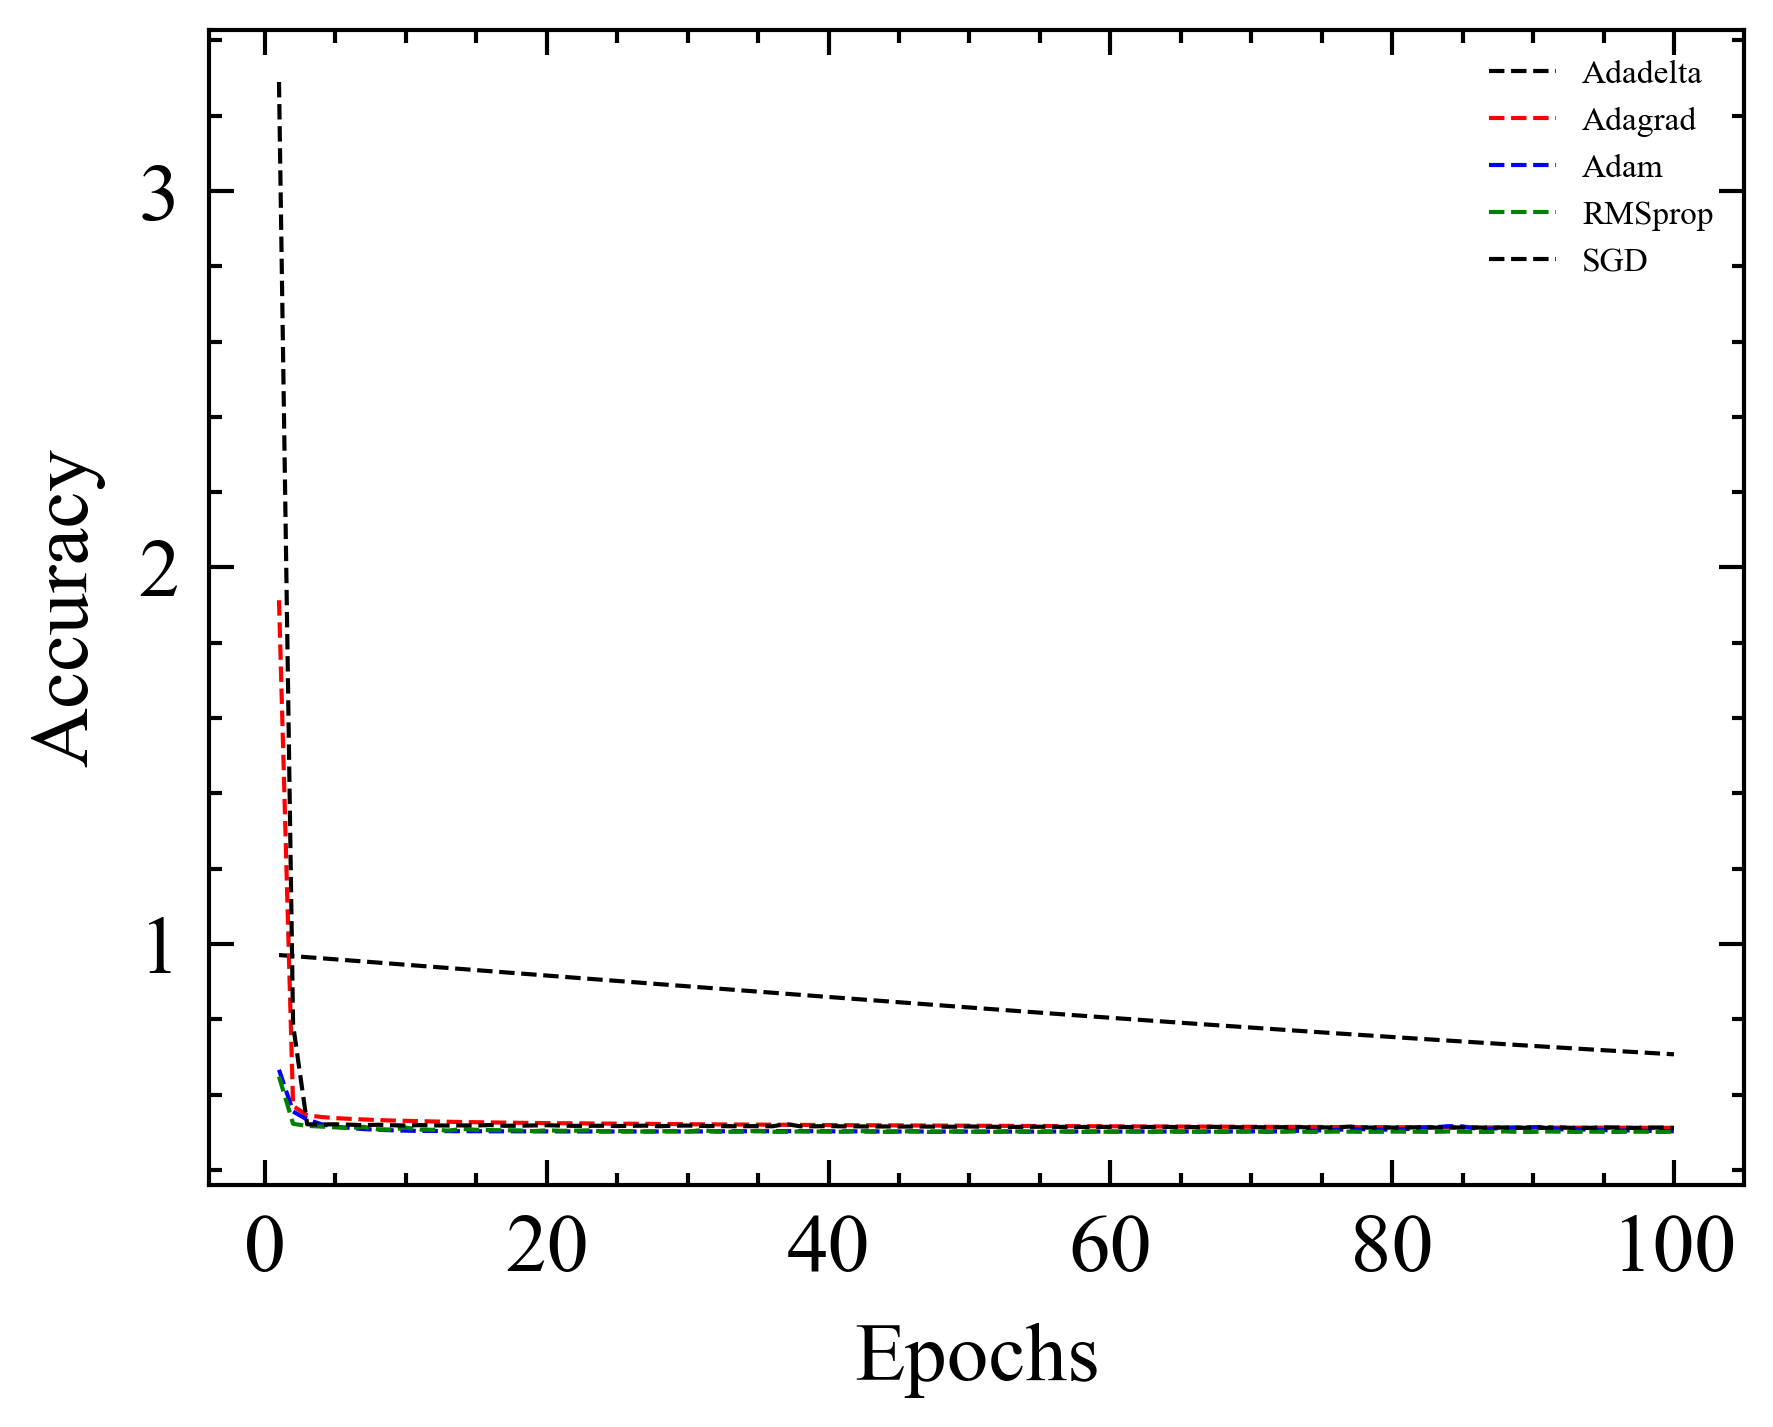

In [91]:
plt.plot(x, df_unpickle_al_bow_opt['loss'][0], '--', label = 'Adadelta', linewidth = 0.5)
plt.plot(x, df_unpickle_al_bow_opt['loss'][1], '--', label = 'Adagrad',  linewidth = 0.5)
plt.plot(x, df_unpickle_al_bow_opt['loss'][2], '--', label = 'Adam',  linewidth = 0.5)
plt.plot(x, df_unpickle_al_bow_opt['loss'][3], '--', label = 'RMSprop', linewidth = 0.5)
plt.plot(x, df_unpickle_al_bow_opt['loss'][4], '--', label = 'SGD',  linewidth = 0.5)
plt.legend(prop = {'size':4})
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

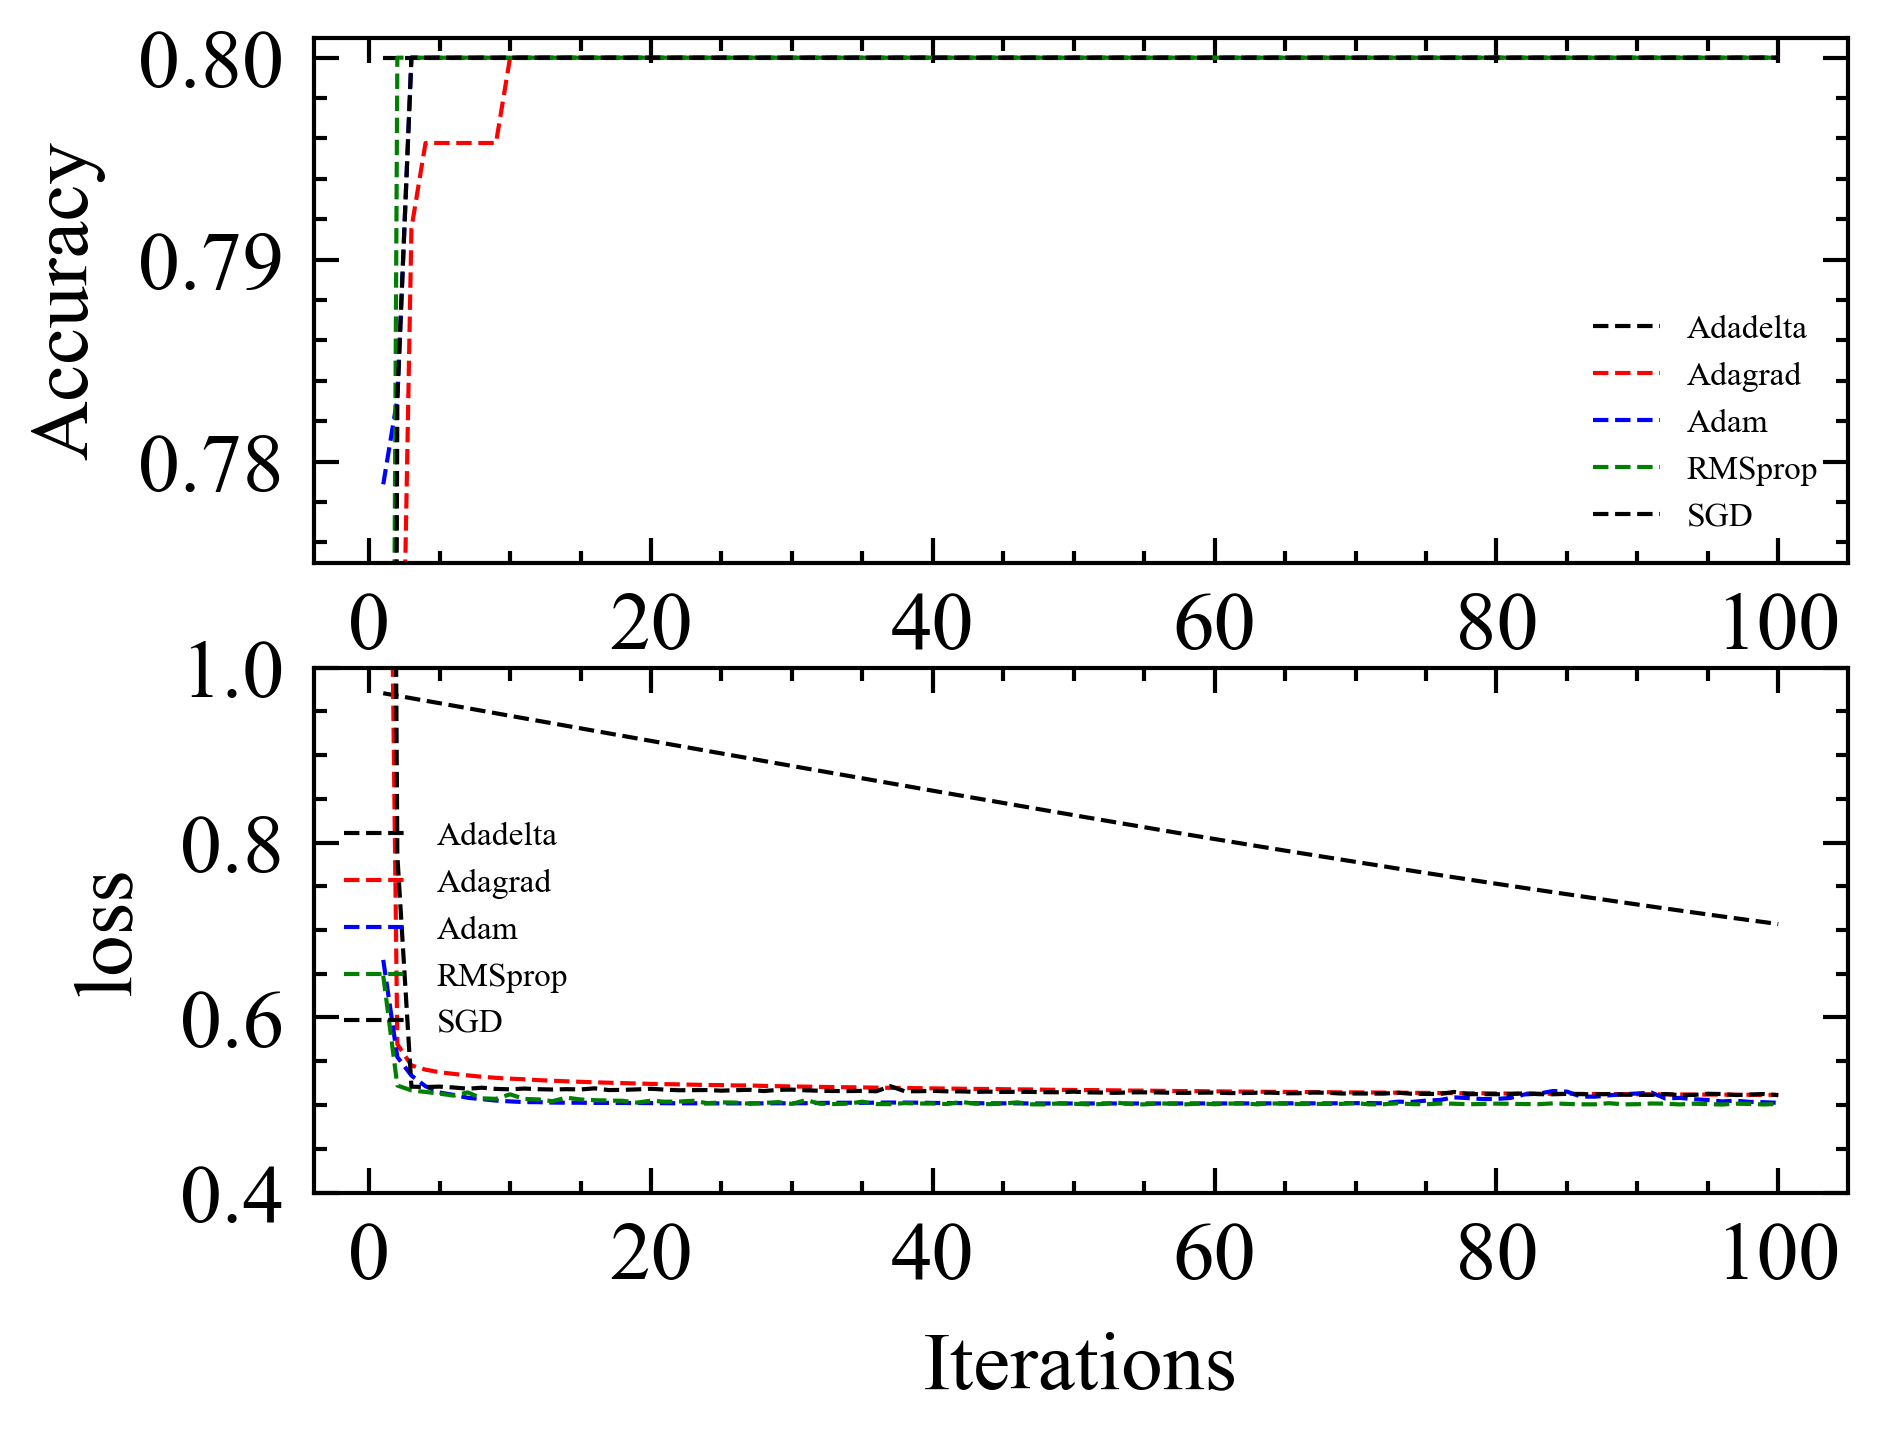

In [93]:
# Subplots of accuracy and loss graphs 
fig = plt.figure()
plt.subplot(2,1,1)
plt.plot(x, df_unpickle_al_bow_opt['accuracy'][0], '--', label = 'Adadelta', linewidth = 0.5)
plt.plot(x, df_unpickle_al_bow_opt['accuracy'][1], '--', label = 'Adagrad',  linewidth = 0.5)
plt.plot(x, df_unpickle_al_bow_opt['accuracy'][2], '--', label = 'Adam',  linewidth = 0.5)
plt.plot(x, df_unpickle_al_bow_opt['accuracy'][3], '--', label = 'RMSprop', linewidth = 0.5)
plt.plot(x, df_unpickle_al_bow_opt['accuracy'][4], '--', label = 'SGD',  linewidth = 0.5)
plt.ylim(0.775, 0.801)
plt.legend( prop = {'size':4})
plt.ylabel('Accuracy')
plt.xlabel('Iterations')


plt.subplot(2,1,2)
plt.plot(x, df_unpickle_al_bow_opt['loss'][0], '--', label = 'Adadelta', linewidth = 0.5)
plt.plot(x, df_unpickle_al_bow_opt['loss'][1], '--', label = 'Adagrad',  linewidth = 0.5)
plt.plot(x, df_unpickle_al_bow_opt['loss'][2], '--', label = 'Adam',  linewidth = 0.5)
plt.plot(x, df_unpickle_al_bow_opt['loss'][3], '--', label = 'RMSprop', linewidth = 0.5)
plt.plot(x, df_unpickle_al_bow_opt['loss'][4], '--', label = 'SGD',  linewidth = 0.5)
plt.ylim(0.4,1.0)
plt.legend(prop = {'size':4})
plt.ylabel('loss')
plt.xlabel('Iterations')


# plt.subplot(3,1,3)
# plt.plot(x, df_unpickle_al_bow_opt['val_loss'][0], '--', label = 'Adadelta', linewidth = 0.5)
# plt.plot(x, df_unpickle_al_bow_opt['val_loss'][1], '--', label = 'Adagrad',  linewidth = 0.5)
# plt.plot(x, df_unpickle_al_bow_opt['val_loss'][2], '--', label = 'Adam',  linewidth = 0.5)
# plt.plot(x, df_unpickle_al_bow_opt['val_loss'][3], '--', label = 'RMSprop', linewidth = 0.5)
# plt.plot(x, df_unpickle_al_bow_opt['val_loss'][4], '--', label = 'SGD',  linewidth = 0.5)
# plt.ylim(0.4,1.5)
# plt.legend(prop = {'size':4})
# plt.ylabel(' Val loss')
# plt.xlabel('Iterations')

# plt.rcParams.update({'font.size': 10})
plt.show()

### Batch size investigation

In [106]:
def NN_batch(model1, input1, ephs, X_t, y_t, X_test, y_test, node1, node2, node3, bsize):
    maxlen = 100 
    model = model1
    model.add(layers.Dense(node1, input_dim = input, activation  = 'relu'))
    model.add(layers.Dense(node2, input_dim = input, activation  = 'relu'))
    model.add(layers.Dense(node3 ,activation = 'sigmoid'))
    model.add(layers.Flatten())
    model.compile(loss= 'binary_crossentropy', optimizer= 'Adam', metrics= ['accuracy'])
    model.build(input1)
    model.summary()
    history = model.fit(X_t,y_t,epochs = ephs, verbose=True, validation_data=(X_test, y_test), batch_size=bsize)
    return history


Batchsize = [32,64,128,256]
def NN_data_batch(X, y,tsize, epoch_no, node1, node2, node3, batch_sizes):
    accuracy = []
    loss     = []
    val_loss = []
    for i in batch_sizes:
        X_train_b, X_test_b, y_train_b, y_test_b = train_test_split(X, y , train_size = tsize)
        input = X_train_b.shape[1] 
        nn1 = NN_batch(Sequential(), input, epoch_no, X_train_b, y_train_b, X_test_b, y_test_b, node1, node2, node3, i)
        accuracy.append(nn1.history['accuracy'])
        loss.append(nn1.history['loss'])
        val_loss.append(nn1.history['val_loss'])
    dictionary = {'accuracy':accuracy, 'loss': loss, 'val_loss':val_loss, 'batch': batch_sizes}
    df = pd.DataFrame(dictionary)
    return df

In [132]:
Batchsize = [32,64,128,256]
df_bow_al_batch = NN_data_batch(X_y1y2_bow_al, y_y1y2_bow_al,0.8, 500, 12, 8, 1, Batchsize)

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_39 (Dense)            (None, 12)                90768     
                                                                 
 dense_40 (Dense)            (None, 8)                 104       
                                                                 
 dense_41 (Dense)            (None, 1)                 9         
                                                                 
 flatten_13 (Flatten)        (None, 1)                 0         
                                                                 
Total params: 90,881
Trainable params: 90,881
Non-trainable params: 0
_________________________________________________________________
Epoch 1/500
5/5 [==============================] - 1s 54ms/step - loss: 1.1762 - accuracy: 0.6690 - val_loss: 0.7709 - val_accuracy: 0.8000
Epoch 2/500
5/5 [========================

In [133]:
df_pickle_bow_al_batch = utils.save_as_pickle_file(df_bow_al_batch,'NN_investigations_y1y2_500epochs_batch_investigation_new', dir_name_e)

In [134]:
df_unpickle_bow_al_batch= utils.load_pickle_file_to_df('NN_investigations_y1y2_500epochs_batch_investigation_new', dir_name_e)

Text(0.5, 0, 'Iterations')

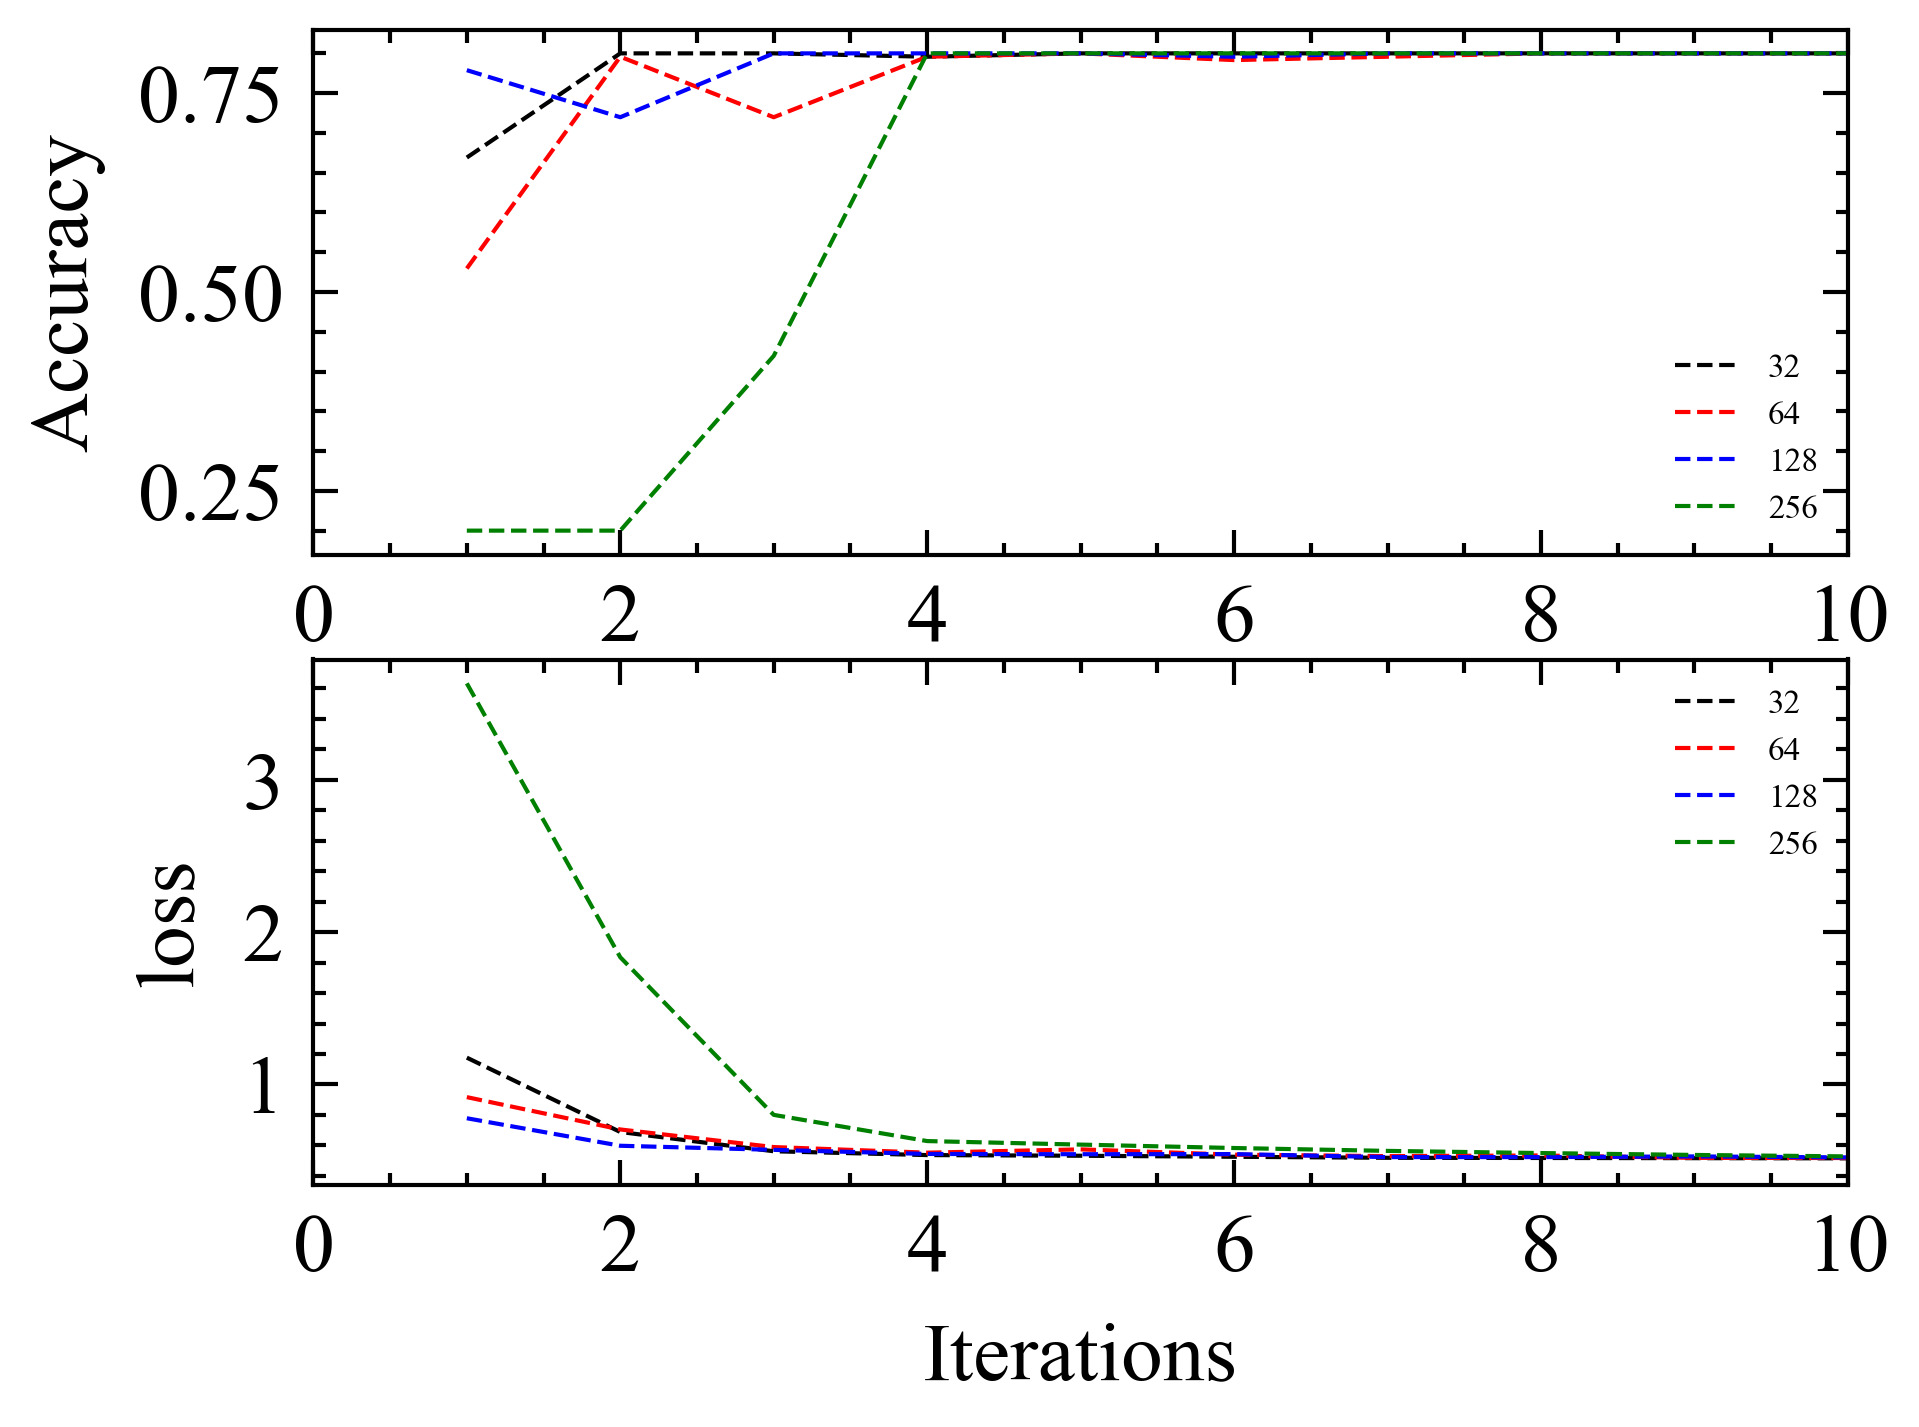

In [141]:
# Subplots of accuracy and loss graphs 

fig = plt.figure()
plt.subplot(2,1,1)
plt.plot(x, df_unpickle_bow_al_batch['accuracy'][0], '--', label = '32', linewidth = 0.5)
plt.plot(x, df_unpickle_bow_al_batch['accuracy'][1], '--', label = '64',  linewidth = 0.5)
plt.plot(x, df_unpickle_bow_al_batch['accuracy'][2], '--', label = '128',  linewidth = 0.5)
plt.plot(x, df_unpickle_bow_al_batch['accuracy'][3], '--', label = '256', linewidth = 0.5)
#plt.ylim(0.5,0.85)
plt.xlim(0,10)
plt.legend( prop = {'size':4})
plt.ylabel('Accuracy')
plt.xlabel('Iterations')


plt.subplot(2,1,2)
plt.plot(x, df_unpickle_bow_al_batch['loss'][0], '--', label = '32', linewidth = 0.5)
plt.plot(x, df_unpickle_bow_al_batch['loss'][1], '--', label = '64',  linewidth = 0.5)
plt.plot(x, df_unpickle_bow_al_batch['loss'][2], '--', label = '128',  linewidth = 0.5)
plt.plot(x, df_unpickle_bow_al_batch['loss'][3], '--', label = '256', linewidth = 0.5)
#plt.ylim(0,2)
plt.xlim(0,10)
plt.legend(prop = {'size':4})
plt.ylabel('loss')
plt.xlabel('Iterations')

### Learning rate

In [13]:
# have to build new NN as I do not want to mix keras and tensorflow
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM, BatchNormalization
from keras.callbacks import TensorBoard
from keras.callbacks import ModelCheckpoint
from keras.optimizers import Adam
from keras.layers import Dense
from keras.models import Sequential
from keras.optimizers import SGD
from keras.utils import to_categorical
from matplotlib import pyplot

In [21]:

def NN_opt(model1, input1, ephs, X_t, y_t, X_test, y_test, node1, node2, node3,lrate):
    maxlen = 100 
    model = model1
    model.add(Dense(node1, input_dim = input1, activation  = 'relu'))
    model.add(Dense(node2, input_dim = input1, activation  = 'relu'))
    model.add(Dense(node3,  activation = 'sigmoid'))
    model.add(layers.Flatten())
    opt = Adam(learning_rate= lrate)
    model.compile(loss= 'binary_crossentropy', optimizer= opt, metrics= ['accuracy'])
    model.build(input1)
    model.summary()
    history = model.fit(X_t,y_t,epochs = ephs, verbose=True, validation_data=(X_test, y_test), batch_size=30 )
    
     # plot learning curves
    pyplot.plot(history.history['accuracy'], '--', label='train', linewidth = 0.5)
    pyplot.plot(history.history['val_accuracy'],'--', label='test', linewidth = 0.5)
    pyplot.plot(history.history['loss'],'--', label = 'loss', linewidth = 0.5)
    pyplot.plot(history.history['val_loss'],'--', label = 'val_loss', linewidth = 0.5)
    pyplot.title('lrate='+str(lrate), pad=-50, fontsize=5)
    pyplot.legend(prop = {'size':2})
    return 


# optimizers = ['Adadelta', 'Adagrad', 'Adam', 'RMSprop', 'SGD']
# def NN_data_opt(X, y, tsize, epoch_no, node1, node2, node3, opt):
#     accuracy = []
#     loss     = []
#     val_loss = []
#     for i in opt:
#         X_train_b, X_test_b, y_train_b, y_test_b = train_test_split(X, y , train_size = tsize)
#         input = X_train_b.shape[1] 
#         nn1 = NN_opt(Sequential(), input, epoch_no, X_train_b, y_train_b, X_test_b, y_test_b, node1, node2, node3, i)
#         accuracy.append(nn1.history['accuracy'])
#         loss.append(nn1.history['loss'])
#         val_loss.append(nn1.history['val_loss'])
#     dictionary = {'accuracy':accuracy, 'loss': loss, 'val_loss':val_loss}
#     df = pd.DataFrame(dictionary)
#     return df

In [22]:
X_train_b, X_test_b, y_train_b, y_test_b = train_test_split(X_y1y2_bow_al, y_y1y2_bow_al, train_size = 0.8)
print(X_train_b.shape[1])
type(X_train_b.shape[1])

7563


int

Model: "sequential_24"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_72 (Dense)            (None, 12)                90768     
                                                                 
 dense_73 (Dense)            (None, 8)                 104       
                                                                 
 dense_74 (Dense)            (None, 1)                 9         
                                                                 
 flatten_24 (Flatten)        (None, 1)                 0         
                                                                 
Total params: 90,881
Trainable params: 90,881
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
5/5 [==============================] - 1s 46ms/step - loss: 0.9338 - accuracy: 0.8000 - val_loss: 0.9724 - val_accuracy: 0.8000
Epoch 2/100
5/5 [========================

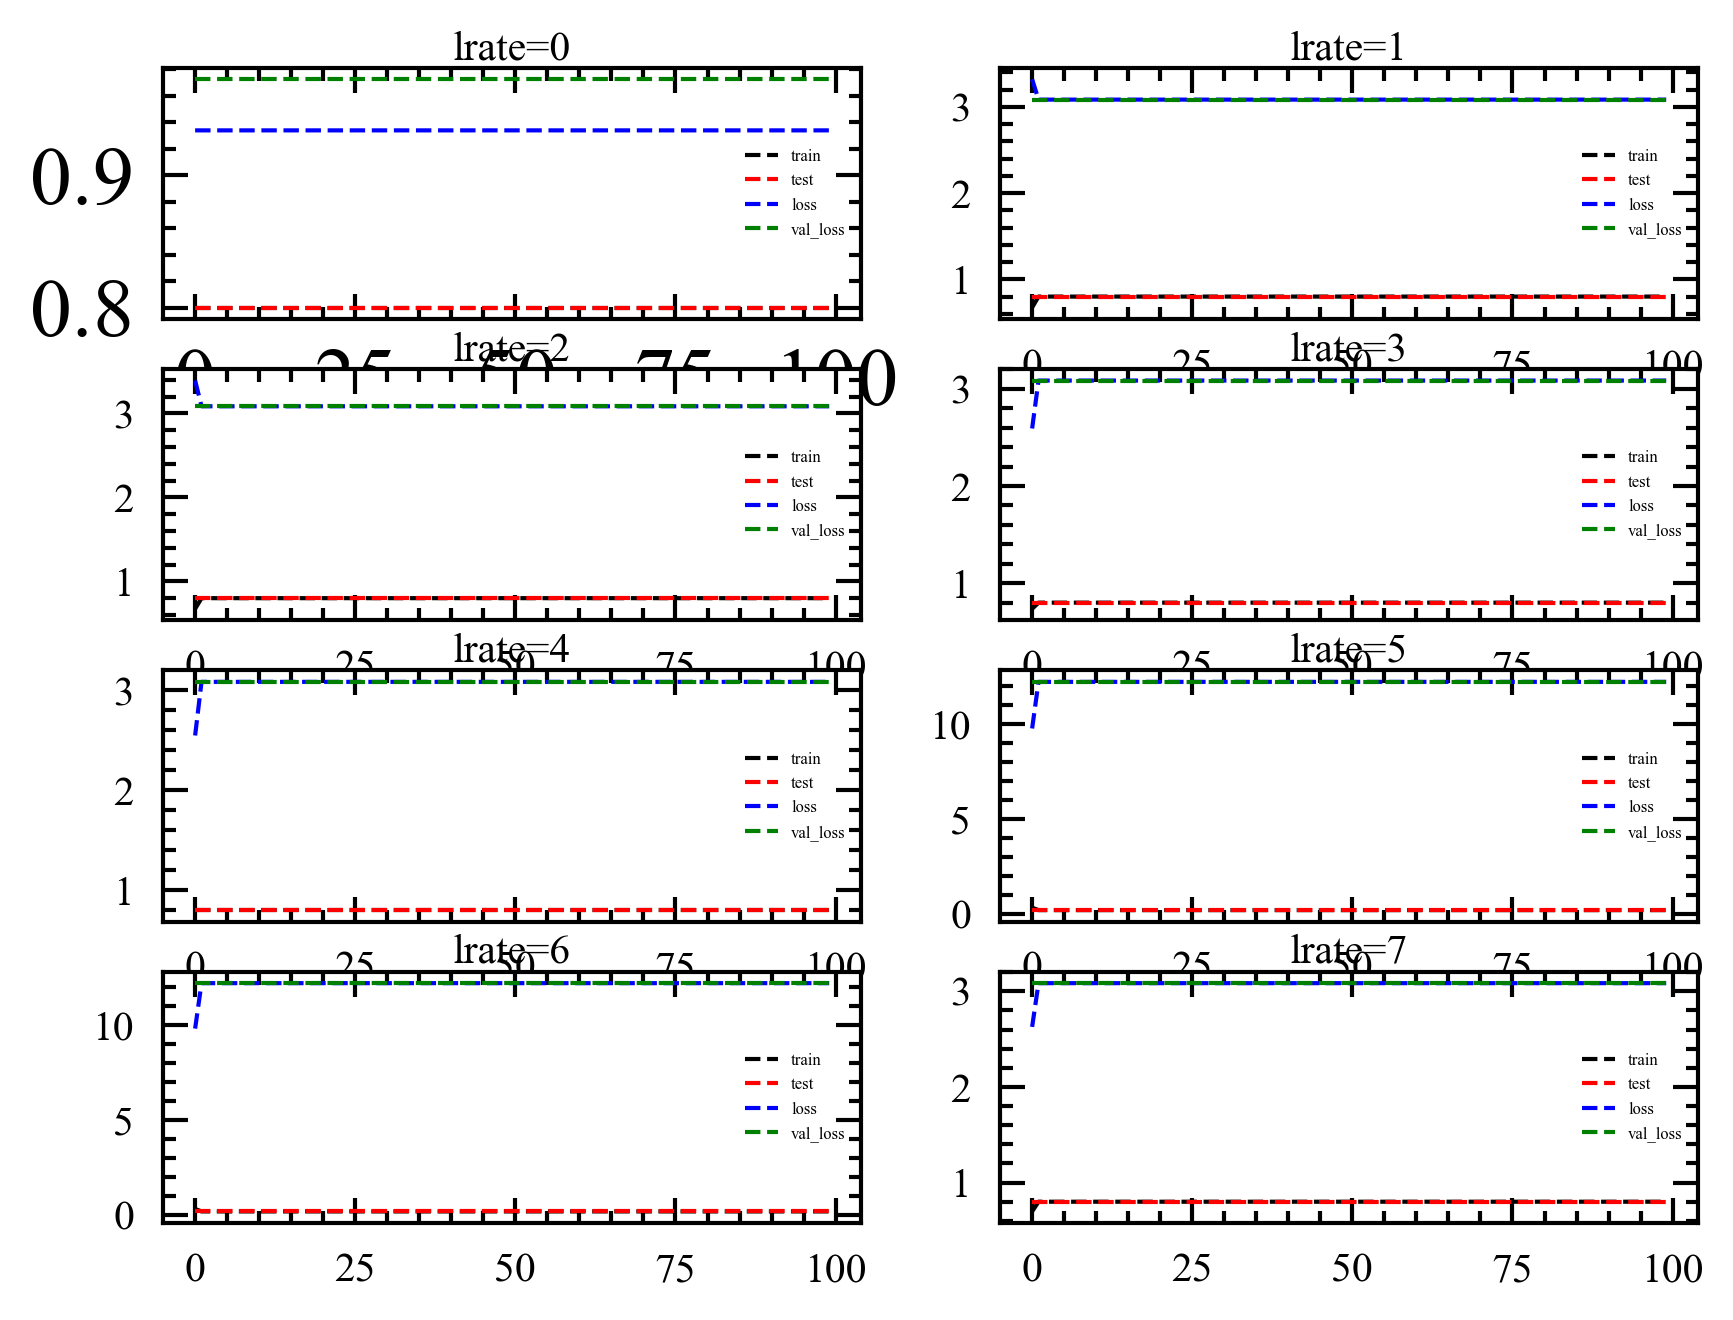

In [24]:

learning_rates = [1E-0, 1E-1, 1E-2, 1E-3, 1E-4, 1E-5, 1E-6, 1E-7]


for i in range(len(learning_rates)):
    plot_no = 420 + (i+1)
    pyplot.subplot(plot_no)
    NN_opt(Sequential(), X_train_b.shape[1], 100, X_train_b, y_train_b, X_test_b, y_test_b, 12, 8, 1, i)
    plt.rc('xtick', labelsize=5)
    plt.rc('ytick', labelsize=5)

# show learning curves
pyplot.show()


# 4. Bayesian Optimisation

###### Code reference: https://www.analyticsvidhya.com/blog/2021/05/tuning-the-hyperparameters-and-layers-of-neural-network-deep-learning/

In [26]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from keras.models import Sequential
from keras.layers import Dense, BatchNormalization, Dropout
from keras.optimizers import Adam, SGD, RMSprop, Adadelta, Adagrad, Adamax, Nadam, Ftrl
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.wrappers.scikit_learn import KerasClassifier
from math import floor
from sklearn.metrics import make_scorer, accuracy_score
from bayes_opt import BayesianOptimization
from sklearn.model_selection import StratifiedKFold
from keras.layers import LeakyReLU
LeakyReLU = LeakyReLU(alpha=0.1)
import warnings
warnings.filterwarnings('ignore')
pd.set_option("display.max_columns", None)

In [27]:
# Make scorer accuracy
score_acc = make_scorer(accuracy_score)

In [44]:
from sklearn.utils.multiclass import type_of_target
type_of_target(y_y1y2_bow_al)
y_y1y2_bow_al = np.argmax(y_y1y2_bow_al, axis = 1)
#print(y_y1y2_bow_al)

In [45]:
X_train, X_test, y_train, y_test = train_test_split(X_y1y2_bow_al, y_y1y2_bow_al , train_size = 0.7, random_state = 1)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=1) # 0.25 x 0.8

In [46]:
# Create function
def nn_cl_bo2(neurons, activation, optimizer, learning_rate, batch_size, epochs,
              layers1, layers2, normalization, dropout, dropout_rate):
    optimizerL = ['SGD', 'Adam', 'RMSprop', 'Adadelta', 'Adagrad', 'Adamax', 'Nadam', 'Ftrl','SGD']
    optimizerD= {'Adam':Adam(lr=learning_rate), 'SGD':SGD(lr=learning_rate),
                 'RMSprop':RMSprop(lr=learning_rate), 'Adadelta':Adadelta(lr=learning_rate),
                 'Adagrad':Adagrad(lr=learning_rate), 'Adamax':Adamax(lr=learning_rate),
                 'Nadam':Nadam(lr=learning_rate), 'Ftrl':Ftrl(lr=learning_rate)}
    activationL = ['relu', 'sigmoid', 'softplus', 'softsign', 'tanh', 'selu',
                   'elu', 'exponential', LeakyReLU,'relu']
    neurons = round(neurons)
    activation = activationL[round(activation)]
    optimizer = optimizerD[optimizerL[round(optimizer)]]
    batch_size = round(batch_size)
    epochs = round(epochs)
    layers1 = round(layers1)
    layers2 = round(layers2)
    def nn_cl_fun():
        nn = Sequential()
        nn.add(Dense(neurons, input_dim= 7563, activation=activation))
        if normalization > 0.5:
            nn.add(BatchNormalization())
        for i in range(layers1):
            nn.add(Dense(neurons, activation=activation))
        if dropout > 0.5:
            nn.add(Dropout(dropout_rate, seed=123))
        for i in range(layers2):
            nn.add(Dense(neurons, activation=activation))
        nn.add(Dense(1, activation='sigmoid'))
        nn.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
        return nn
    
    
    es = EarlyStopping(monitor='accuracy', mode='max', verbose=0, patience=20)
    nn = KerasClassifier(build_fn=nn_cl_fun, epochs=epochs, batch_size=batch_size, verbose=0)
    kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=123)
    score = cross_val_score(nn,X_train, y_train,  scoring=score_acc, cv=kfold, fit_params={'callbacks':[es]}).mean()
    return score

In [47]:
params_nn2 ={
    'neurons': (10, 100),
    'activation':(0, 9),
    'optimizer':(0,7),
    'learning_rate':(0.01, 1),
    'batch_size':(200, 1000),
    'epochs':(20, 100),
    'layers1':(1,3),
    'layers2':(1,3),
    'normalization':(0,1),
    'dropout':(0,1),
    'dropout_rate':(0,0.3)
    
}

In [48]:
# Run Bayesian Optimization
nn_bo = BayesianOptimization(nn_cl_bo2, params_nn2, random_state=111)
nn_bo.maximize(init_points=25, n_iter=4)

|   iter    |  target   | activa... | batch_... |  dropout  | dropou... |  epochs   |  layers1  |  layers2  | learni... |  neurons  | normal... | optimizer |
-------------------------------------------------------------------------------------------------------------------------------------------------------------
1/1 [==============================] - 0s 89ms/step
| 1         | 0.1076    | 5.51      | 335.3     | 0.4361    | 0.2308    | 43.63     | 1.298     | 1.045     | 0.426     | 31.48     | 0.3377    | 6.935     |
1/1 [==============================] - 0s 138ms/step
| 2         | 0.1076    | 2.14      | 265.0     | 0.6696    | 0.1864    | 41.94     | 1.932     | 1.237     | 0.08322   | 91.07     | 0.794     | 5.884     |
1/1 [==============================] - 0s 80ms/step
| 3         | 0.1825    | 7.337     | 992.8     | 0.5773    | 0.2441    | 53.71     | 1.055     | 1.908     | 0.1143    | 83.55     | 0.6977    | 3.957     |
1/1 [==============================] - 0s 70ms/step
|

In [49]:
params_nn_ = nn_bo.max['params']
learning_rate = params_nn_['learning_rate']
activationL = ['relu', 'sigmoid', 'softplus', 'softsign', 'tanh', 'selu',
               'elu', 'exponential', LeakyReLU,'relu']
params_nn_['activation'] = activationL[round(params_nn_['activation'])]
params_nn_['batch_size'] = round(params_nn_['batch_size'])
params_nn_['epochs'] = round(params_nn_['epochs'])
params_nn_['layers1'] = round(params_nn_['layers1'])
params_nn_['layers2'] = round(params_nn_['layers2'])
params_nn_['neurons'] = round(params_nn_['neurons'])
optimizerL = ['Adam', 'SGD', 'RMSprop', 'Adadelta', 'Adagrad', 'Adamax', 'Nadam', 'Ftrl','Adam']
optimizerD= {'Adam':Adam(lr=learning_rate), 'SGD':SGD(lr=learning_rate),
             'RMSprop':RMSprop(lr=learning_rate), 'Adadelta':Adadelta(lr=learning_rate),
             'Adagrad':Adagrad(lr=learning_rate), 'Adamax':Adamax(lr=learning_rate),
             'Nadam':Nadam(lr=learning_rate), 'Ftrl':Ftrl(lr=learning_rate)}
params_nn_['optimizer'] = optimizerD[optimizerL[round(params_nn_['optimizer'])]]
params_nn_

{'activation': 'exponential',
 'batch_size': 993,
 'dropout': 0.5772738296076794,
 'dropout_rate': 0.2441300751109463,
 'epochs': 54,
 'layers1': 1,
 'layers2': 2,
 'learning_rate': 0.11427282446194219,
 'neurons': 84,
 'normalization': 0.6977277345956326,
 'optimizer': <keras.optimizers.optimizer_v2.adagrad.Adagrad at 0x159ad336ac0>}

In [50]:
# Fitting Neural Network
def nn_cl_fun():
    nn = Sequential()
    nn.add(Dense(params_nn_['neurons'], input_dim=7563, activation=params_nn_['activation']))
    if params_nn_['normalization'] > 0.5:
        nn.add(BatchNormalization())
    for i in range(params_nn_['layers1']):
        nn.add(Dense(params_nn_['neurons'], activation=params_nn_['activation']))
    if params_nn_['dropout'] > 0.5:
        nn.add(Dropout(params_nn_['dropout_rate'], seed=123))
    for i in range(params_nn_['layers2']):
        nn.add(Dense(params_nn_['neurons'], activation=params_nn_['activation']))
        nn.add(Dense(1, activation='sigmoid'))
        nn.compile(loss='binary_crossentropy', optimizer=params_nn_['optimizer'], metrics=['accuracy'])
    return nn

es = EarlyStopping(monitor='accuracy', mode='max', verbose=0, patience=20)
nn = KerasClassifier(build_fn=nn_cl_fun, epochs=params_nn_['epochs'], batch_size=params_nn_['batch_size'],
                         verbose=0)


In [51]:
nn2 = nn.fit(X_train, y_train, validation_data=(X_val, y_val), verbose=1)

Epoch 1/54
1/1 [==============================] - 1s 1s/step - loss: nan - accuracy: 0.1398 - val_loss: nan - val_accuracy: 0.0968
Epoch 2/54
1/1 [==============================] - 0s 50ms/step - loss: nan - accuracy: 0.1828 - val_loss: nan - val_accuracy: 0.0968
Epoch 3/54
1/1 [==============================] - 0s 50ms/step - loss: nan - accuracy: 0.1828 - val_loss: nan - val_accuracy: 0.0968
Epoch 4/54
1/1 [==============================] - 0s 61ms/step - loss: nan - accuracy: 0.1828 - val_loss: nan - val_accuracy: 0.0968
Epoch 5/54
1/1 [==============================] - 0s 52ms/step - loss: nan - accuracy: 0.1828 - val_loss: nan - val_accuracy: 0.0968
Epoch 6/54
1/1 [==============================] - 0s 49ms/step - loss: nan - accuracy: 0.1828 - val_loss: nan - val_accuracy: 0.0968
Epoch 7/54
1/1 [==============================] - 0s 48ms/step - loss: nan - accuracy: 0.1828 - val_loss: nan - val_accuracy: 0.0968
Epoch 8/54
1/1 [==============================] - 0s 45ms/step - loss: 

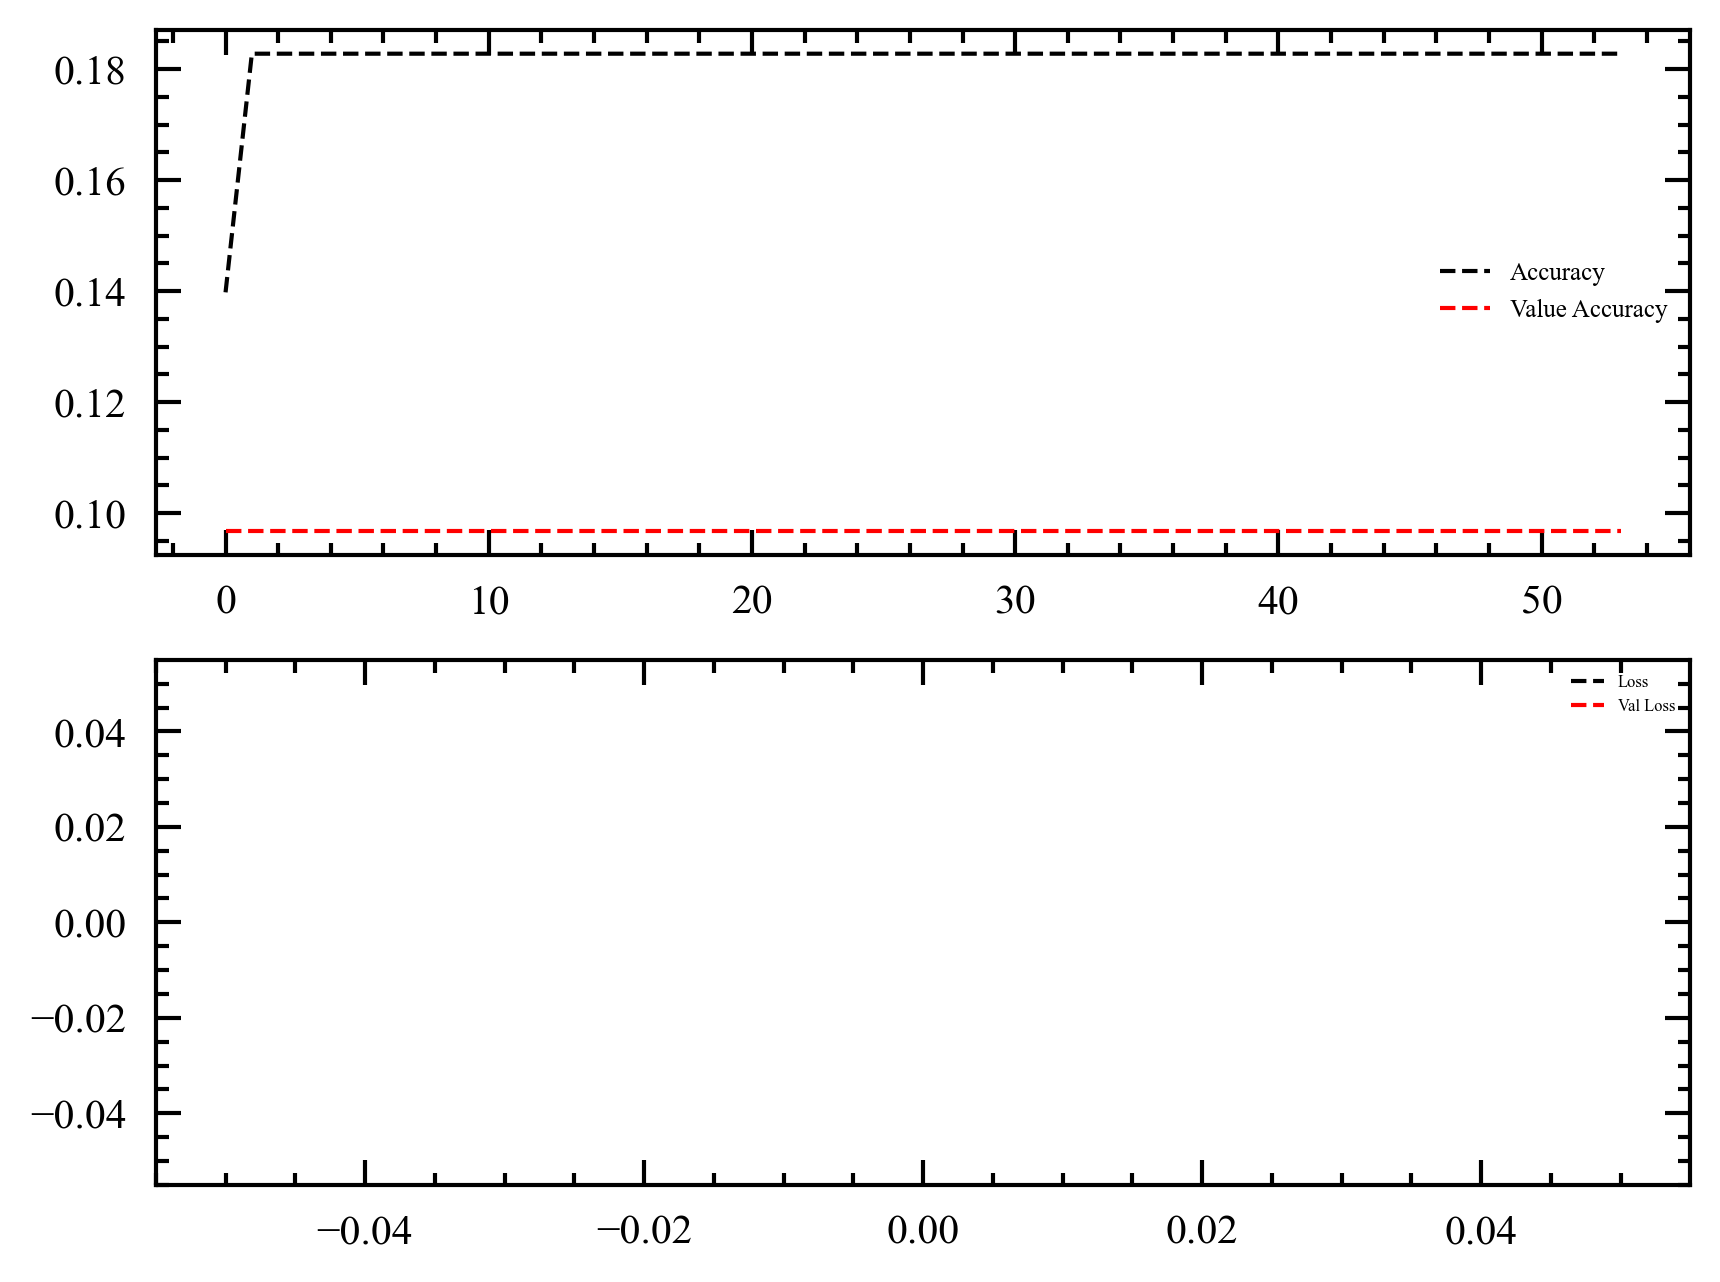

In [52]:
plt.subplot(2,1,1)
plt.plot(nn2.history['accuracy'], '--', linewidth = 0.5, label = 'Accuracy')
plt.plot(nn2.history['val_accuracy'], '--', linewidth = 0.5, label = 'Value Accuracy')
plt.legend(prop = {'size':3})

plt.subplot(2,1,2)
plt.plot(nn2.history['loss'], '--', linewidth = 0.5, label = 'Loss')
plt.plot(nn2.history['val_loss'], '--', linewidth = 0.5, label = 'Val Loss')
plt.legend(prop = {'size':2})
